In [1]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.inspection import permutation_importance


import json

import matplotlib.pyplot as plt
%run func_declarations.ipynb

\begin{subfigure}{0.3\textwidth} 
    \includegraphics[width=\textwidth]{figs/student/student002_MLU_AoA.png} 
    \caption{figs/student/student002 MLU AoA} 
    \end{subfigure} 
    \hfill 
    \begin{subfigure}{0.3\textwidth} 
    \includegraphics[width=\textwidth]{figs/student/student002_TTR_utterances_words_scaffolding_proportion.png} 
    \caption{figs/student/student002 TTR utterances words scaffolding proportion} 
    \end{subfigure} 
    \hfill 
    \begin{subfigure}{0.3\textwidth} 
    \includegraphics[width=\textwidth]{figs/student/student002_WF.png} 
    \caption{figs/student/student002 WF} 
    \end{subfigure} 
    \hfill 
    \begin{subfigure}{0.3\textwidth} 
    \includegraphics[width=\textwidth]{figs/student/student003_MLU_AoA.png} 
    \caption{figs/student/student003 MLU AoA} 
    \end{subfigure} 
    \hfill 
    \begin{subfigure}{0.3\textwidth} 
    \includegraphics[width=\textwidth]{figs/student/student003_TTR_utterances_words_scaffolding_proportion.png} 
    \captio

C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\305697343.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  previous_utts = pd.concat(
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\305697343.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  previous_utts = pd.concat(
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\3500320797.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty o

In [2]:
for student, contents in student_group:
    n_student_dialogues = len(contents)
    print(student)
    student_chats = []
    # The chats are already sorted by their timestamps, so I don't have to sort them
    for chat_num in contents['chat.num']:
        student_chats.append(chatrooms[chat_num-2])

    students_progress[student] = {
        'MLU': [],
        'AoA': [],
        'WF': [],
        'TTR': [],
        'utterances': [],
        'words': [],
        'rare': [],
        'timegaps': [0] + get_student_timegaps(student,contents), # setting the first element to 0, for the first lesson (as there is no gap)
        'scaffolding_proportion': []
    }

    for chat in student_chats:
        students_progress[student]['MLU'].append(chat_MLU(chat)[2])
        students_progress[student]['utterances'].append(chat_utterance_proportion(chat))
        students_progress[student]['words'].append(chat_words_proportion(chat))
        students_progress[student]['scaffolding_proportion'].append(calc_scaffolding_proportion(chat))

        # TTR
        token_list_student = []
        token_list_teacher = []

        # WF
        wf_chat_total, wf_chat_teacher, wf_chat_student = 0, 0, 0
        tokens_total, tokens_teacher, tokens_student = 0, 0, 0
        rare_total, rare_teacher, rare_student = 0, 0, 0

        #AOA
        aoa_chat_total, aoa_chat_teacher, aoa_chat_student = 0, 0, 0

        for index, utt in chat.iterrows():
            utterance = utt['anonymised']
            role = utt['role']
            wf_utt, aoa_utt = 0, 0
            wf_n_tokens, aoa_n_tokens = 0, 0

            utterance = utterance.replace('<STUDENT>', '')
            utterance = utterance.replace('<TEACHER>', '')
            tokens = tokenize_and_preprocess(utterance, False)

            tokens_total += len(tokens)

            for token in tokens:
                if token in AoA_list['Word'].values:
                    # print(token)
                    # print(AoA_list[AoA_list['Word'] == token]['AoA_Kup_lem'].item())
                    aoa_utt += AoA_list[AoA_list['Word'] == token]['AoA_Kup_lem'].item()
                    aoa_n_tokens += 1
                if token not in stoplist and token in WF_list_billion['word'].values:
                    try:
                        index = WF_list_billion.index[WF_list_billion['word'] == token].tolist()[0]
                    except:
                        print(token)
                        # print(WF_list_billion.loc[WF_list_billion['word'] == token])
                    wf_utt += index
                    wf_n_tokens += 1
                else:
                    rare_total += 1
                    # print(token, 'not in list')
                    if role == 'teacher':
                        rare_teacher += 1
                    elif role == 'student':
                        rare_student += 1
            wf_utt = wf_utt/wf_n_tokens if wf_n_tokens > 0 else wf_utt
            wf_chat_total += wf_utt

            aoa_utt = aoa_utt/aoa_n_tokens if aoa_n_tokens > 0 else aoa_utt
            aoa_chat_total += aoa_utt

            if role == 'teacher':
                wf_chat_teacher += wf_utt
                tokens_teacher += len(tokens)
                token_list_teacher += tokens
                aoa_chat_teacher += aoa_utt
            elif role == 'student':
                wf_chat_student += wf_utt
                tokens_student += len(tokens)
                token_list_student += tokens
                aoa_chat_student += aoa_utt

        wf_chat_total /= len(chat['anonymised'])
        wf_chat_student /= len(chat[chat['role'].str.contains('student')])
        wf_chat_teacher /= len(chat[chat['role'].str.contains('teacher')])

        aoa_chat_total /= len(chat['anonymised'])
        aoa_chat_student /= len(chat[chat['role'].str.contains('student')])
        aoa_chat_teacher /= len(chat[chat['role'].str.contains('teacher')])

        students_progress[student]['AoA'].append(aoa_chat_student)
        students_progress[student]['WF'].append(wf_chat_student)
        students_progress[student]['TTR'].append(len(set(token_list_student))/len(token_list_student))
        students_progress[student]['rare'].append(rare_student/tokens_student)


    print(students_progress[student])

Here, I inspect the progress that students made within single classes, comparing the first with the second half of the dialogue

In [184]:
students_progress_halves = {}

for student, contents in student_group:
    n_student_dialogues = len(contents)
    print(student)
    student_chats = []
    # The chats are already sorted by their timestamps, so I don't have to sort them
    for chat_num in contents['chat.num']:
        student_chats.append(chatrooms[chat_num-2])

    students_progress_halves[student] = {
        'MLU': [],
        'AoA': [],
        'WF': [],
        'TTR': [],
        'utterances': [],
        'words': [],
        'rare': [],
        'timegaps': [0] + get_student_timegaps(student,contents), # setting the first element to 0, for the first lesson (as there is no gap)
        'scaffolding_proportion': []
    }

    for chat in student_chats:
        # print(len(chat))
        chat1 = chat[:int(len(chat)/2)]
        chat2 = chat[int(len(chat)/2):]

        students_progress_halves[student]['MLU'].append((chat_MLU(chat1)[2], chat_MLU(chat2)[2]))
        students_progress_halves[student]['AoA'].append((chat_AoA(chat1)[2], chat_AoA(chat2)[2]))
        students_progress_halves[student]['WF'].append((chat_WF(chat1)[2], chat_WF(chat2)[2]))
        students_progress_halves[student]['TTR'].append((chat_TTR(chat1)[2], chat_TTR(chat2)[2]))
        students_progress_halves[student]['utterances'].append((chat_utterance_proportion(chat1), chat_utterance_proportion(chat2)))
        students_progress_halves[student]['words'].append((chat_words_proportion(chat1), chat_words_proportion(chat2)))
        students_progress_halves[student]['rare'].append((chat_WF(chat1)[5], chat_WF(chat2)[5]))
        students_progress_halves[student]['scaffolding_proportion'].append((calc_scaffolding_proportion(chat1), calc_scaffolding_proportion(chat2)))


    print(students_progress_halves[student])

student002
highest
{'MLU': [(6.863636363636363, 8.277777777777779), (4.411764705882353, 7.333333333333333), (7.636363636363637, 5.722222222222222)], 'AoA': [(5.373810686363635, 5.273801474074075), (5.953646196078431, 5.890969133333332), (5.233876028138528, 3.6992529861111105)], 'WF': [(2678.013636363636, 3242.3899470899473), (5622.851960784314, 4280.398566618566), (6265.205194805195, 2521.834259259259)], 'TTR': [(0.5185185185185185, 0.6242038216560509), (0.6976744186046512, 0.6929824561403509), (0.6162790697674418, 0.6261682242990654)], 'utterances': [(0.4782608695652174, 0.391304347826087), (0.4594594594594595, 0.39473684210526316), (0.4888888888888889, 0.391304347826087)], 'words': [(0.300796812749004, 0.26371681415929205), (0.18115942028985507, 0.15558698727015557), (0.2662440570522979, 0.19397363465160075)], 'rare': [(0.0, 0.0), (0.0, 0.01639344262295082), (0.0, 0.0)], 'timegaps': [0, 17, 6], 'scaffolding_proportion': [(0.041666666666666664, 0.14285714285714285), (0.15, 0.217391304


KeyboardInterrupt



In [4]:
for student, contents in student_group:
    gaps = get_student_timegaps(student, contents)
    print([0]+gaps)

[0, 17, 6]
[0, 6, 37, 7]
[0, 6, 0, 2, 34, 0, 6, 1, 5, 47, 0, 4, 1, 1, 1, 2, 1, 0, 1, 0, 2, 0, 1, 0, 1, 4, 2, 8]
[0, 2, 7, 6, 6, 18]
[0, 7, 5, 18]
[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]
[0, 4, 2, 4, 2, 12, 2, 8, 4, 0, 4, 1, 1, 3, 2, 4, 2, 33, 2, 11, 6, 1, 12, 3, 3, 6, 3, 3, 3, 4, 6, 3, 3, 2, 27, 11, 7, 6, 7, 7, 16, 13, 20, 14, 7, 6, 6, 20]
[0, 1, 5, 2, 11, 1, 5, 2, 4, 7, 2, 6, 5, 5]
[0, 2, 5, 1, 10, 23, 1, 5, 1, 5, 2, 7, 4, 1, 4, 7, 1, 18, 6, 2, 3, 2, 5, 2, 5, 1, 3, 1, 7, 1, 4, 2, 4, 7, 1, 10, 3, 16, 3, 3, 4, 4, 1, 7, 5, 2, 7, 2, 2, 23, 0]
[0, 14, 6, 21, 13, 7, 7, 6, 27, 5, 15, 8, 5, 12, 9, 4, 9, 18, 6, 7, 9, 6, 7, 6, 14, 7]
[0, 7, 14, 6, 7, 7, 14, 27, 9, 5, 10, 4, 6, 13, 7, 7, 6, 7, 20, 7, 7, 6, 7, 15, 12, 7]
[0, 6, 14, 4, 3, 4, 2, 4, 3, 3, 2, 7, 3, 20, 2, 7, 20, 7]


In [6]:
# Plotting each statistic for halves
for student, _ in student_group:
    progress = students_progress_halves[student]
    avg_first = {}
    avg_second = {}
    halves = {}
    for metric in progress.keys():
        if metric != 'timegaps':
        # print(progress[metric])
            avg_first[metric] = np.mean([first for first, second in progress[metric]])
            avg_second[metric] = np.mean([second for first, second in progress[metric]])
            halves[metric] = [avg_first[metric], avg_second[metric]]
    # print(avg_first, avg_second)

    x_values = [1, 2]  # x-values for both pairs

    # Plotting
    plt.plot(x_values, halves['MLU'], marker='o', label='MLU')
    plt.plot(x_values, halves['AoA'], marker='o', label='AoA')
    plt.plot(x_values, halves['TTR'], marker='o', label='TTR')
    plt.plot(x_values, halves['utterances'], marker='o', label='utterances')
    plt.plot(x_values, halves['words'], marker='o', label='words')
    plt.legend()

    # Adding labels and title
    plt.xlabel('Half of the dialogue')
    plt.ylabel('Value')
    plt.title(f"{student} in-dialogue average progress")
    plt.xticks([1,2])

    # Show plot
    plt.grid(True)
    plt.show()


In [2]:
student_grade_over_time = json.load(open('student_grade_over_time.txt'))
student_grade_over_time

{'student002': {'chat_index': [2, 5, 9],
  'previous_chat_index': [-1, 2, 5],
  'fk_prev': [0, 3.858260383386586, 4.941664427526497],
  'fk_curr': [3.858260383386586, 4.941664427526497, 3.3727384341637006],
  'MLU_prev': [0, 7.5, 5.78125],
  'MLU_curr': [7.5, 5.78125, 6.775],
  'AoA_prev': [0, 4.7936503319451385, 5.43921455598136],
  'AoA_curr': [4.7936503319451385, 5.43921455598136, 4.756632576919124],
  'WF_prev': [0, 2931.9829761904757, 4993.576932269119],
  'WF_curr': [2931.9829761904757, 4993.576932269119, 4580.688273809524],
  'TTR_prev': [0, 0.47335423197492166, 0.605],
  'TTR_curr': [0.47335423197492166, 0.605, 0.5412186379928315],
  'utt_ratio_prev': [0, 0.43478260869565216, 0.4266666666666667],
  'utt_ratio_curr': [0.43478260869565216,
   0.4266666666666667,
   0.43956043956043955],
  'words_ratio_prev': [0, 0.28116213683223995, 0.16503122212310437],
  'words_ratio_curr': [0.28116213683223995,
   0.16503122212310437,
   0.2332185886402754],
  'timegaps': [0, 17, 6],
  'fk_del

In [4]:
for student, _ in student_group:
    students_progress[student]['fk'] = student_grade_over_time[student]['fk_curr']
students_progress

{'student002': {'MLU': [7.5, 5.78125, 6.775],
  'AoA': [4.7936503319451385, 5.43921455598136, 4.756632576919124],
  'WF': [2931.9829761904757, 4993.576932269119, 4580.688273809524],
  'TTR': [0.47335423197492166, 0.605, 0.5412186379928315],
  'utterances': [0.43478260869565216, 0.4266666666666667, 0.43956043956043955],
  'words': [0.28116213683223995, 0.16503122212310437, 0.2332185886402754],
  'rare': [0.5203761755485894, 0.49, 0.5448028673835126],
  'timegaps': [0, 17, 6],
  'scaffolding_proportion': [0.09615384615384616,
   0.18604651162790697,
   0.0392156862745098],
  'fk': [3.858260383386586, 4.941664427526497, 3.3727384341637006]},
 'student003': {'MLU': [7.888888888888889,
   7.6875,
   8.422222222222222,
   10.18918918918919],
  'AoA': [4.891089391913579,
   4.569759901571463,
   4.7621696481392135,
   5.365991290447884],
  'WF': [3699.3490069190075,
   4961.750446428571,
   3450.3705908289244,
   3395.010541223041],
  'TTR': [0.4613259668508287,
   0.48342541436464087,
   0.4

In [77]:
maxes = {'max_MLU' : max(max([students_progress[student]['MLU'] for student in students_progress.keys()])),
'max_AoA' : max(max([students_progress[student]['AoA'] for student in students_progress.keys()])),
'max_fk' : max(max([students_progress[student]['fk'] for student in students_progress.keys()])),
'max_WF' : max(max([students_progress[student]['WF'] for student in students_progress.keys()])),
'max_TTR' : max(max([students_progress[student]['TTR'] for student in students_progress.keys()])),
'max_utterances' : max(max([students_progress[student]['utterances'] for student in students_progress.keys()])),
'max_words' : max(max([students_progress[student]['words'] for student in students_progress.keys()])),
'max_scaffolding_proportion' : max(max([students_progress[student]['scaffolding_proportion'] for student in students_progress.keys()]))
}
mins = {'min_MLU' : min(min([students_progress[student]['MLU'] for student in students_progress.keys()])),
'min_AoA' : min(min([students_progress[student]['AoA'] for student in students_progress.keys()])),
'min_fk' : min(min([students_progress[student]['fk'] for student in students_progress.keys()])),
'min_WF' : min(min([students_progress[student]['WF'] for student in students_progress.keys()])),
'min_TTR' : min(min([students_progress[student]['TTR'] for student in students_progress.keys()])),
'min_utterances' : min(min([students_progress[student]['utterances'] for student in students_progress.keys()])),
'min_words' : min(min([students_progress[student]['words'] for student in students_progress.keys()])),
'min_scaffolding_proportion' : min(min([students_progress[student]['scaffolding_proportion'] for student in students_progress.keys()]))
}

In [78]:
maxes

{'max_MLU': 17.771929824561404,
 'max_AoA': 5.365991290447884,
 'max_fk': 7.621617107452931,
 'max_WF': 8136.524757641783,
 'max_TTR': 0.5945945945945946,
 'max_utterances': 0.5217391304347826,
 'max_words': 0.5300707547169812,
 'max_scaffolding_proportion': 0.45918367346938777}

In [79]:
mins

{'min_MLU': 3.5762711864406778,
 'min_AoA': 3.930090785540675,
 'min_fk': 0.6784602547211236,
 'min_WF': 1223.2876603835982,
 'min_TTR': 0.3317307692307692,
 'min_utterances': 0.37894736842105264,
 'min_words': 0.22262443438914026,
 'min_scaffolding_proportion': 0.015873015873015872}

In [36]:
students_progress

{'student002': {'MLU': [7.5, 5.78125, 6.775],
  'AoA': [4.7936503319451385, 5.43921455598136, 4.756632576919124],
  'WF': [2931.9829761904757, 4993.576932269119, 4580.688273809524],
  'TTR': [0.47335423197492166, 0.605, 0.5412186379928315],
  'utterances': [0.43478260869565216, 0.4266666666666667, 0.43956043956043955],
  'words': [0.28116213683223995, 0.16503122212310437, 0.2332185886402754],
  'rare': [0.5203761755485894, 0.49, 0.5448028673835126],
  'timegaps': [0, 17, 6],
  'scaffolding_proportion': [0.09615384615384616,
   0.18604651162790697,
   0.0392156862745098],
  'fk': [3.858260383386586, 4.941664427526497, 3.3727384341637006]},
 'student003': {'MLU': [7.888888888888889,
   7.6875,
   8.422222222222222,
   10.18918918918919],
  'AoA': [4.891089391913579,
   4.569759901571463,
   4.7621696481392135,
   5.365991290447884],
  'WF': [3699.3490069190075,
   4961.750446428571,
   3450.3705908289244,
   3395.010541223041],
  'TTR': [0.4613259668508287,
   0.48342541436464087,
   0.4

In [81]:
for student, values in students_progress.items():
    for measure, measure_values in values.items():
        if measure != 'timegaps':
            min_val = mins[f'min_{measure}']
            max_val = maxes[f'max_{measure}']
    
            for idx in range(len(measure_values)):
                students_progress[student][measure][idx] = (measure_values[idx] - min_val) / (max_val - min_val)

In [82]:
students_progress

{'student002': {'MLU': [-0.23245612164164603,
   -0.24098519041784158,
   -0.23605383792542306],
  'AoA': [-2.3181860569950334, -2.005080512531168, -2.3361400635999594],
  'WF': [-0.176912852884574, -0.17686971684898586, -0.1768783559797966],
  'TTR': [0.7876338485985463, 2.692854389058696, 1.7697896918978042],
  'utterances': [0.08458662064431209,
   -0.31345879903572127,
   0.3189147719473159],
  'words': [-0.10481401967556342, -1.3334104458319505, -0.6120284174389392],
  'timegaps': [0, 17, 6],
  'scaffolding_proportion': [0.18109384221916192,
   0.3838696246951763,
   0.05265533323303746],
  'fk': [0.4579761333512666, 0.6140152474199113, 0.38804800706504344]},
 'student003': {'MLU': [0.303798352185449,
   0.28961169878508586,
   0.3413685239491691,
   0.46584087229248516],
  'AoA': [0.6692654561292225, 0.4454828965131711, 0.5794822550412777, 1.0],
  'WF': [0.3581623647071824,
   0.5407687792926501,
   0.32214762767627275,
   0.3141397944677402],
  'TTR': [0.4930126746831328,
   0.5

In [83]:
all_students_progress = {
    'student': [],
    'value': [],
    'measure': [],
    'timegaps': [],
    'class_index': []
}
for student, _ in student_group:
    progress = students_progress[student]
    gaps = progress['timegaps']
    for key, value in progress.items():
        if key!= 'timegaps':
            i=0
            for val in value:
                all_students_progress['student'].append(student)
                all_students_progress['value'].append(val)
                all_students_progress['measure'].append(key)
                all_students_progress['timegaps'].append(gaps[i])
                all_students_progress['class_index'].append(i+1)
                i+=1

all_students_progress = pd.DataFrame.from_dict(all_students_progress)
all_students_progress[all_students_progress['student']=='student002']

,student,value,measure,timegaps,class_index
0,student002,-0.232456,MLU,0,1
1,student002,-0.240985,MLU,17,2
2,student002,-0.236054,MLU,6,3
3,student002,-2.318186,AoA,0,1
4,student002,-2.005081,AoA,17,2
5,student002,-2.336140,AoA,6,3
6,student002,-0.176913,WF,0,1
7,student002,-0.176870,WF,17,2
8,student002,-0.176878,WF,6,3
9,student002,0.787634,TTR,0,1


C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\1949254916.py:14: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.relplot(x='class_index', y='value', size="timegaps",
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\1949254916.py:14: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.relplot(x='class_index', y='value', size="timegaps",
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\1949254916.py:14: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.relplot(x='class_index', y='value', size="timegaps",
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\1949254916.py:14: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.relplot(x='class_index', y='value', size="timegaps",
C:\Users\kuba\AppData\Local\Temp\ipykernel_22912\1949254916.py:14: UserWarning: The palette list has more values (8) tha

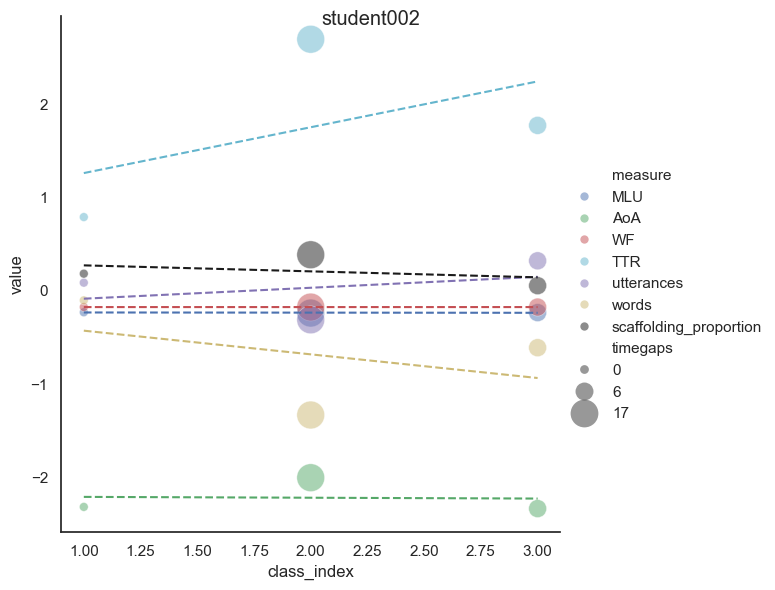

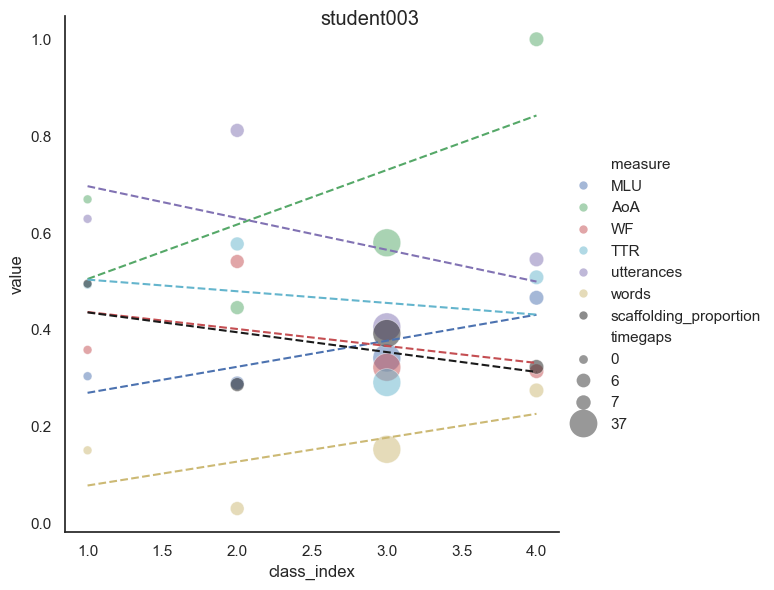

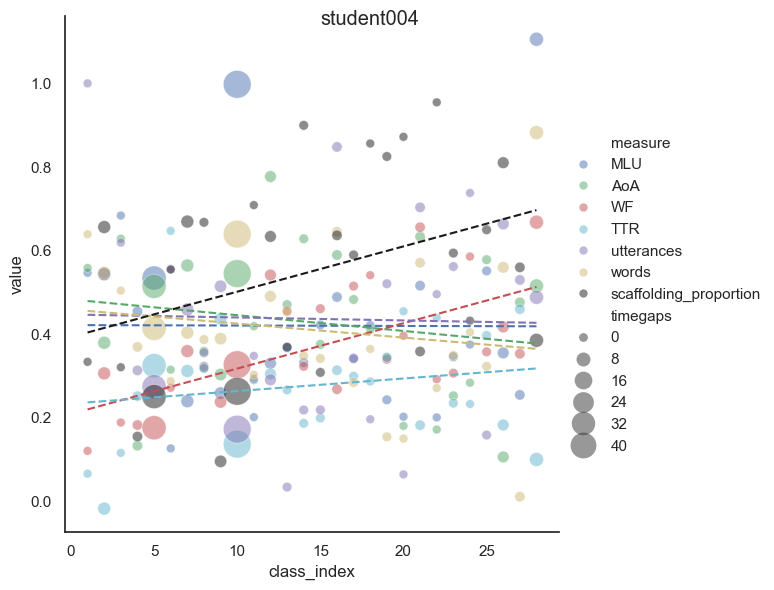

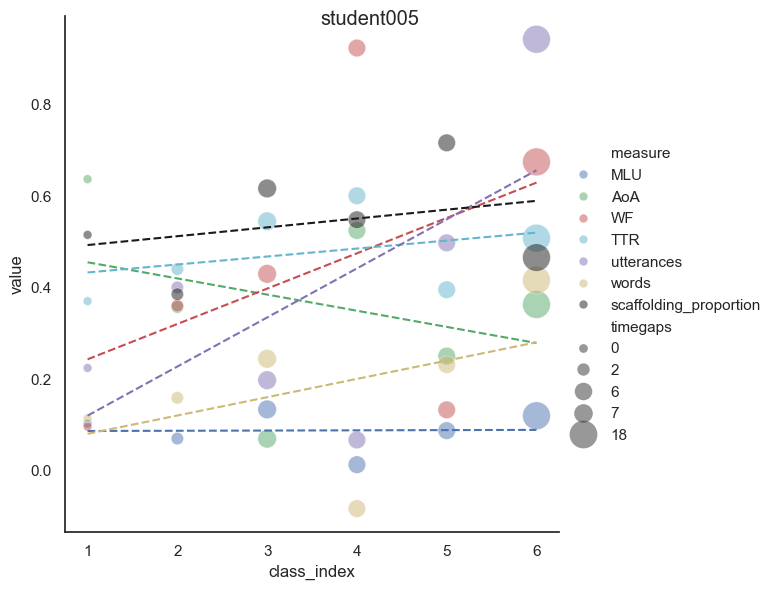

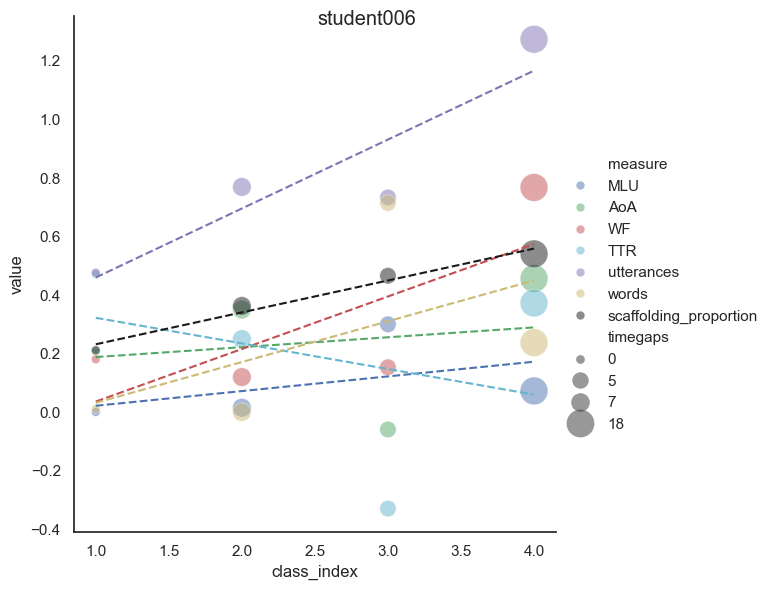

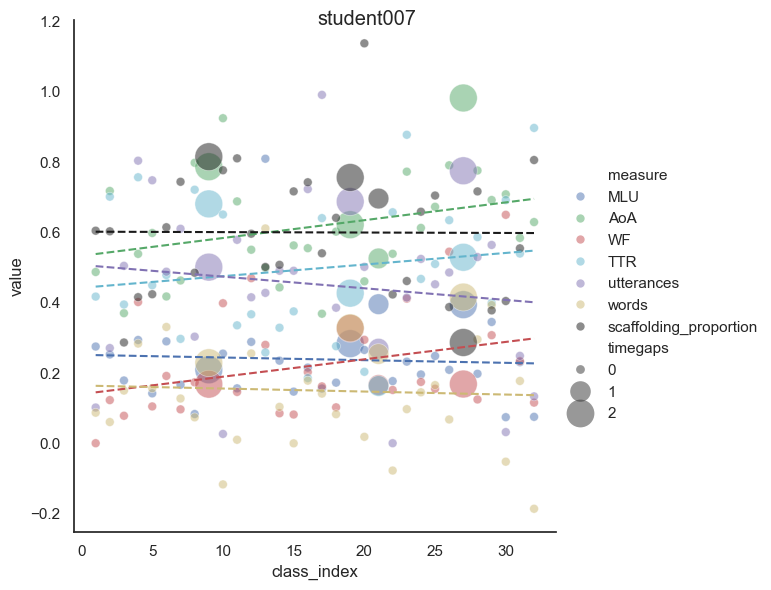

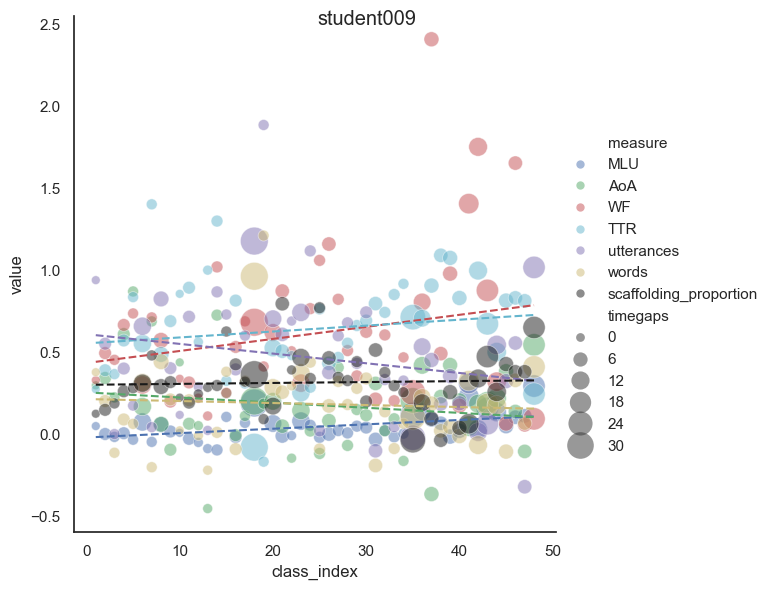

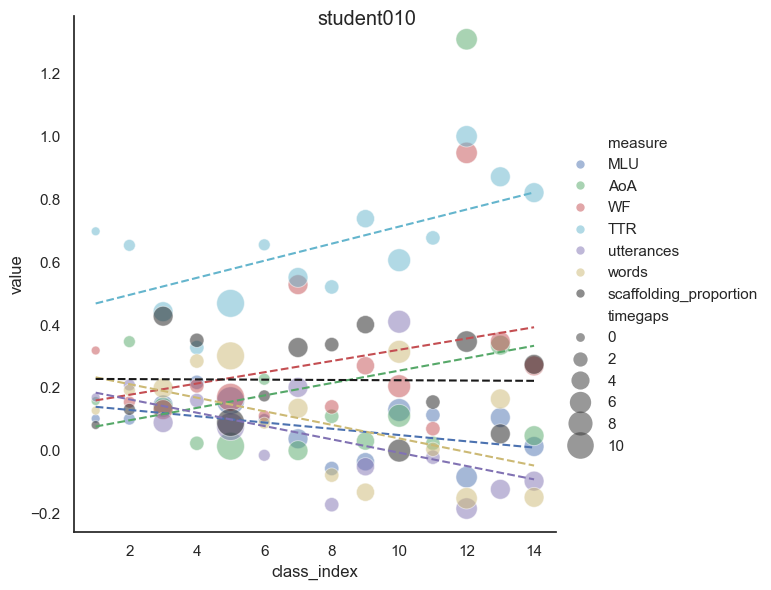

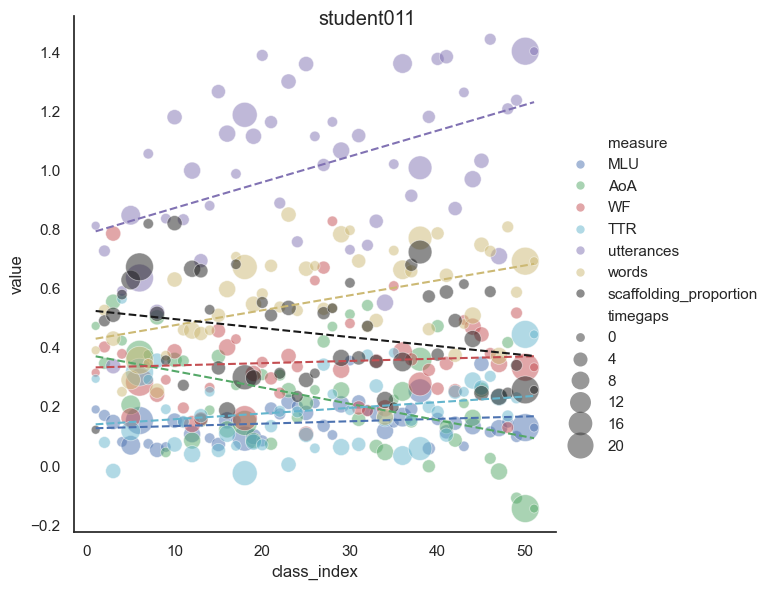

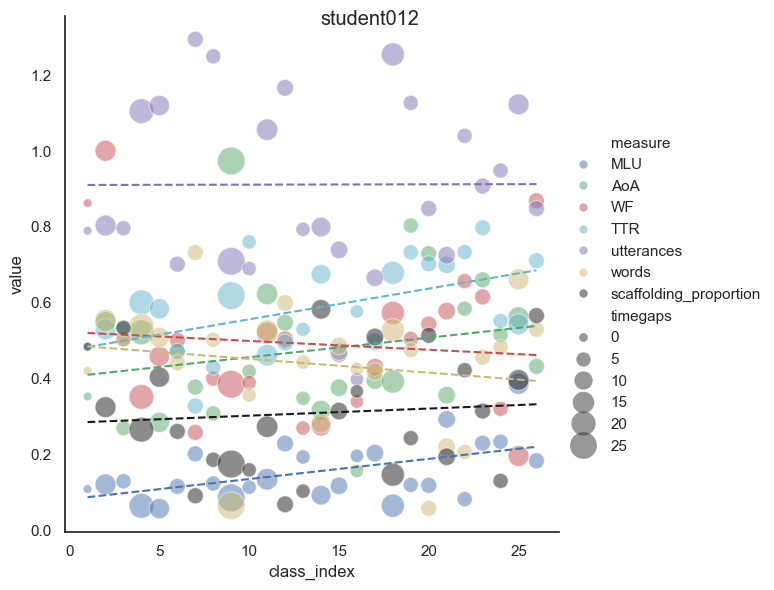

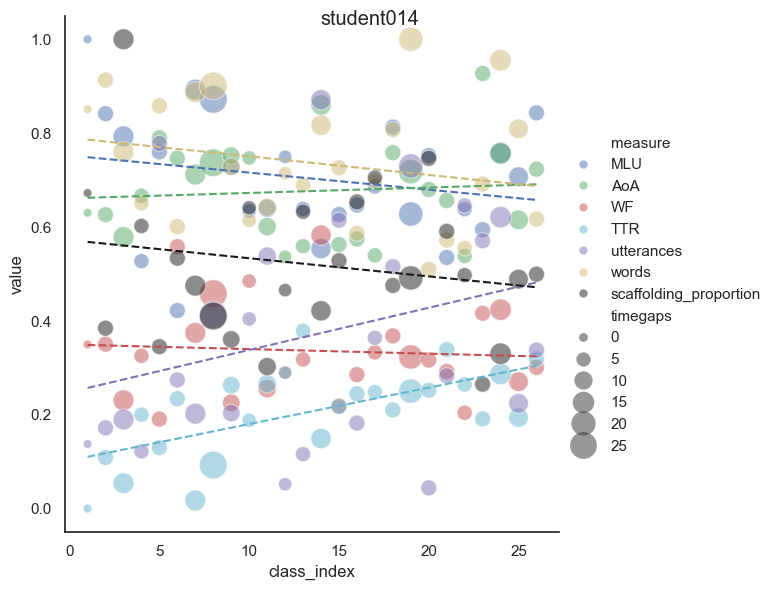

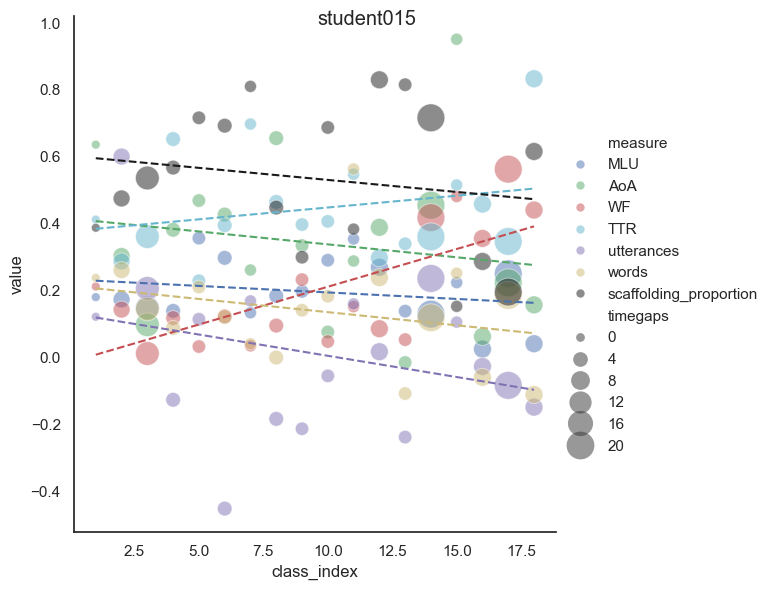

In [87]:
from scipy import stats

student_mean_coeff_scores = {}
iter = 0
for student, _ in student_group:
    coeff_scores = []
    color_order = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    progress = all_students_progress[all_students_progress['student'].str.contains(student)& all_students_progress['measure'].isin(['MLU','AoA', 'TTR','utterances', 'words', 'scaffolding_proportion', 'WF'])]
    x = [y+1 for y in range(max(progress['class_index']))]

    sns.set_theme(style="white")
    sns.relplot(x='class_index', y='value', size="timegaps",
                hue='measure', palette=color_order, sizes=(40, 400), alpha=.5, height=6, data=progress).fig.suptitle(student)
    for i, measure in enumerate(list(dict.fromkeys(progress['measure']))):
        progress_measure = progress.loc[progress['measure'] == measure]  # Get scaled data
        reg = np.polyfit(x, progress_measure['value'], 1)
        pred = np.poly1d(reg)
        coeff = reg[0]
        coeff_scores.append(coeff)

        plt.plot(x, pred(x), f'--{color_order[i]}') 
    # plt.show()
    plt.savefig(f"plots/student/{student}")
    iter+=1

    student_mean_coeff_scores[student] = np.mean(coeff_scores)

In [94]:
for s, v in student_mean_coeff_scores.items():
    print(f"{s} & {v:.6f} &")

student002 & 0.039951 &
student003 & 0.007128 &
student004 & 0.002396 &
student005 & 0.032336 &
student006 & 0.094218 &
student007 & 0.001180 &
student009 & 0.000560 &
student010 & 0.001659 &
student011 & 0.001243 &
student012 & 0.002078 &
student014 & 0.000780 &
student015 & -0.001394 &


In [89]:
for student, content in student_group:  # number of chats of each student
    print(student, len(dict.fromkeys(content['filename'])))

student002 3
student003 4
student004 28
student005 6
student006 4
student007 32
student009 48
student010 14
student011 51
student012 26
student014 26
student015 18


In [15]:
'''Uncomment when I want to run it'''

all_students_progress_halves = {
    'student': [],
    'value': [],
    'measure': [],
    'timegaps': [],
    'class_index': []
}
for student, _ in student_group:
    progress = students_progress[student]
    # print(progress)
    gaps = progress['timegaps']
    # print(gaps)
    for key, value in progress.items():
        if key!= 'timegaps':
            i=0
            for val in value:
                all_students_progress['student'].append(student)
                all_students_progress['value'].append(val)
                all_students_progress['measure'].append(key)
                all_students_progress['timegaps'].append(gaps[i])
                all_students_progress['class_index'].append(i+1)
                i+=1

all_students_progress = pd.DataFrame.from_dict(all_students_progress)
all_students_progress.loc[all_students_progress['measure']=='rare', 'value'] *= 1000
all_students_progress[all_students_progress['student']=='student002']

metric_progress_halves = {}
for metric in students_progress_halves['student002'].keys():
    if metric != 'timegaps':  # not interested in this one, it doesn't change within one dialogue
        avg_first, avg_second = {}, {}
        for student in students_progress_halves.keys():
            tuples = students_progress_halves[student][metric]
            # print(tuples)
            avg_first[student] = np.mean([tup[0] for tup in tuples])
            avg_second[student] = np.mean([tup[1] for tup in tuples])
        metric_progress_halves[metric] = avg_first, avg_second

metric_progress_halves

In [16]:
for measure, (first_half, second_half) in metric_progress_halves.items():
    x_values = list(first_half.keys())  # Assuming students are consistent across measures

    # Extracting y-values for first and second halves
    data_pairs = [(first, second) for first, second in zip(list(first_half.values()), list(second_half.values()))]
    greater_values = ['blue' if pair[0] > pair[1] else 'red' for pair in data_pairs]
    # print(measure, halves_pairs)
    plt.figure(figsize=(10,6))
    bp = plt.boxplot(data_pairs, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set(color=greater_values[i])
    plt.title(f'Comparison of Average {measure} Values Between First and Second Half')
    plt.xlabel('Student')
    plt.ylabel('Value')
    plt.xticks([1+x for x in range(len(x_values))], x_values, rotation=45)
    plt.grid(True)
    plt.savefig(f'plots/measure/{measure}_halved.png', bbox_inches="tight")
    plt.show()

In [17]:
all_students_progress

,student,value,measure,timegaps,class_index
0,student002,7.500000,MLU,0,1
1,student002,5.781250,MLU,17,2
2,student002,6.775000,MLU,6,3
3,student002,4.793650,AoA,0,1
4,student002,5.439215,AoA,17,2
...,...,...,...,...,...
2075,student015,3.020862,fk,20,14
2076,student015,3.722607,fk,2,15
2077,student015,1.531943,fk,7,16
2078,student015,3.229642,fk,20,17


In [90]:
mean_coeff_scores = {}
for measure in set(all_students_progress['measure']):
    coeff_scores = []

    # I decided to split it in two halves for better readability. Some of the 15 students in one plot were indistinguishable.

    all_students_progress1 = all_students_progress[all_students_progress['student']<='student007']
    all_students_progress2 = all_students_progress[all_students_progress['student']>'student007']

    progress =  all_students_progress.loc[all_students_progress['measure']==measure]
    progress1 = all_students_progress1.loc[all_students_progress['measure']==measure]
    progress2 = all_students_progress2.loc[all_students_progress['measure']==measure]

    color_order_all = [
        "#FF0000",  # Red
        "#00FF00",  # Green
        "#0000FF",  # Blue
        "#FFFF00",  # Yellow
        "#FF00FF",  # Magenta
        "#00FFFF",  # Cyan
        "#800000",  # Maroon
        "#008000",  # Dark Green
        "#000080",  # Navy
        "#FFA500",  # Orange
        "#800080",  # Purple
        "#008080"   # Teal
    ]

    color_order = ['b', 'r', 'g', 'y', 'c', 'm']

    sns.set_theme(style="white")
    sns.relplot(x='class_index', y='value', size="timegaps",
            hue='student', palette=color_order_all, sizes=(40, 400), alpha=.5, height=6, data=progress).fig.suptitle(measure)
    for i, student in enumerate(list(dict.fromkeys(all_students_progress['student']))):
        progress_student = progress[progress['student']==student]
        x = [y+1 for y in range(max(progress_student['class_index']))]
        reg = np.polyfit(x, progress_student['value'], 1)
        pred = np.poly1d(reg)
        coeff_scores.append(reg[0])
        plt.plot(x, pred(x), color=color_order_all[i], linestyle='dashed')

    plt.show()
    plt.savefig(f"plots/measure/{measure}_full.png")

    sns.relplot(x='class_index', y='value', size="timegaps",
                hue='student', palette=color_order, sizes=(40, 400), alpha=.5, height=6, data=progress1).fig.suptitle(measure+' 1')
    for i, student in enumerate(list(dict.fromkeys(all_students_progress[all_students_progress['student']<='student007']['student']))):
        progress_student = progress1[progress1['student']==student]
        x = [y+1 for y in range(max(progress_student['class_index']))]
        reg = np.polyfit(x, progress_student['value'], 1)
        pred = np.poly1d(reg)
        plt.plot(x, pred(x), f'--{color_order[i]}')
    plt.savefig(f"plots/measure/{measure}_1.png")
    sns.relplot(x='class_index', y='value', size="timegaps",
                hue='student', palette=color_order, sizes=(40, 400), alpha=.5, height=6, data=progress2).fig.suptitle(measure+' 2')

    for i, student in enumerate(list(dict.fromkeys(all_students_progress[all_students_progress['student']>'student007']['student']))):
        progress_student = progress2[progress2['student']==student]
        x = [y+1 for y in range(max(progress_student['class_index']))]
        reg = np.polyfit(x, progress_student['value'], 1)
        pred = np.poly1d(reg)
        plt.plot(x, pred(x), f'--{color_order[i]}')
    plt.savefig(f"plots/measure/{measure}_2.png")

    mean_coeff_scores[measure] = np.mean(coeff_scores)

In [95]:
for s, v in mean_coeff_scores.items():
    print(f"{s} & {v:.6f} &")

MLU & 0.007752 &
fk & 0.007977 &
TTR & 0.038237 &
utterances & 0.030675 &
scaffolding_proportion & 0.001801 &
AoA & 0.009424 &
words & -0.005197 &
WF & 0.023554 &


In [20]:
list(dict.fromkeys(all_students_progress[all_students_progress['student']<='student007']['student']))

['student002',
 'student003',
 'student004',
 'student005',
 'student006',
 'student007']

In [21]:
all_students_progress[all_students_progress['student']<='student007']

,student,value,measure,timegaps,class_index
0,student002,7.500000,MLU,0,1
1,student002,5.781250,MLU,17,2
2,student002,6.775000,MLU,6,3
3,student002,4.793650,AoA,0,1
4,student002,5.439215,AoA,17,2
...,...,...,...,...,...
611,student007,5.088667,fk,0,28
612,student007,4.863435,fk,0,29
613,student007,5.492449,fk,0,30
614,student007,2.784729,fk,0,31


## Understanding scaffolding utterances

In [22]:
chatrooms_dropped = chatrooms_all.dropna(subset=['seq.type'])

scaffolding_utts = chatrooms_dropped[chatrooms_dropped['seq.type'].str.contains('scaffolding')]
scaffolding_utts

,timestamp,user.id,role,turn.number,anonymised,edited,responding.to,sequence,seq.type,focus,resource,assessment,nWords
44,2019-11-17 12:29:31,teacher001,teacher,45,the the the the the the the the but only once ...,the the the the the the the the but only once ...,NaN,NaN,scaffolding,NaN,NaN,NaN,12
52,2019-11-17 12:33:25,teacher001,teacher,53,Thanks great example ..and nice that you know ...,Thanks great example ..and nice that you know ...,NaN,5c,scaffolding,NaN,NaN,NaN,23
73,2019-11-17 12:52:18,teacher001,teacher,74,Yes good point! So hotels/theatres/cinemas/mus...,Yes good point! So hotels/theatres/cinemas/mus...,NaN,8c,"scaffolding,eliciting",grammatical resource,NaN,NaN,23
75,2019-11-17 12:54:02,teacher001,teacher,76,Ah you live quite centrally - I'm jealous! (so...,Ah you live quite centrally - I'm jealous! (so...,NaN,8d,"scaffolding,eliciting",grammatical resource,NaN,NaN,30
77,2019-11-17 12:56:38,teacher001,teacher,78,Yeah that's it basically! so the 'someone' is ...,Yeah that's it basically! so the 'someone' is ...,NaN,8e,"scaffolding,eliciting",NaN,NaN,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41365,2021-06-18 10:00:42,teacher008,teacher,78,"Yes, someone who works down the mine. A coal m...","Yes, someone who works down the mine. A coal m...",NaN,NaN,scaffolding,"lexical resource,meaning",NaN,NaN,23
41366,2021-06-18 10:00:50,teacher008,teacher,79,"or a gold mine, if you're lucky :)","or a gold mine, if you're lucky :)",NaN,NaN,scaffolding,lexical resource,NaN,NaN,8
41369,2021-06-18 10:01:25,teacher008,teacher,82,"Yes, like in Donbass (at least there used to b...","Yes, like in Donbass (at least there used to b...",NaN,NaN,scaffolding,lexical resource,NaN,NaN,11
41373,2021-06-18 10:02:51,teacher008,teacher,86,No worries! There used to be a lot of mines in...,No worries! There used to be a lot of mines in...,84.0,NaN,scaffolding,"lexical resource,world knowledge",NaN,NaN,39


In [23]:
preceding_turns_scaff = chatrooms_all.iloc[scaffolding_utts.index-1]

In [24]:
# Calculate vocabulary overlap
overlaps = []
repeated_pos = []
for (scaffolding, previous, responding) in zip(scaffolding_utts['anonymised'], preceding_turns_scaff['anonymised'], scaffolding_utts.dropna(subset=['responding.to'])['responding.to']):
    # if responding is not None:
    #     print(f"Scaffolding - {scaffolding}\n"
    #           f"Replying to {responding}\n")
    overlap = 0
    # print(scaffolding)
    scaffolding_tokens = tokenize_and_preprocess(scaffolding, True)

    previous_tokens = tokenize_and_preprocess(previous, True)

    # if(len(scaffolding_tokens) == 0):
    #     print(scaffolding)
    if len(scaffolding_tokens) > 0:
        intersect = set(previous_tokens).intersection(set(scaffolding_tokens))
        union = set(previous_tokens).union(set(scaffolding_tokens))
        
        if len(union) > 0:
            overlaps.append(len(intersect)/len(union))  # jaccard

    repeated = set(previous_tokens)&set(scaffolding_tokens)
    repeated_pos += nltk.pos_tag(repeated)

np.mean(overlaps)
# repeated_pos

0.04103538148706969

In [25]:
len(overlaps)

637

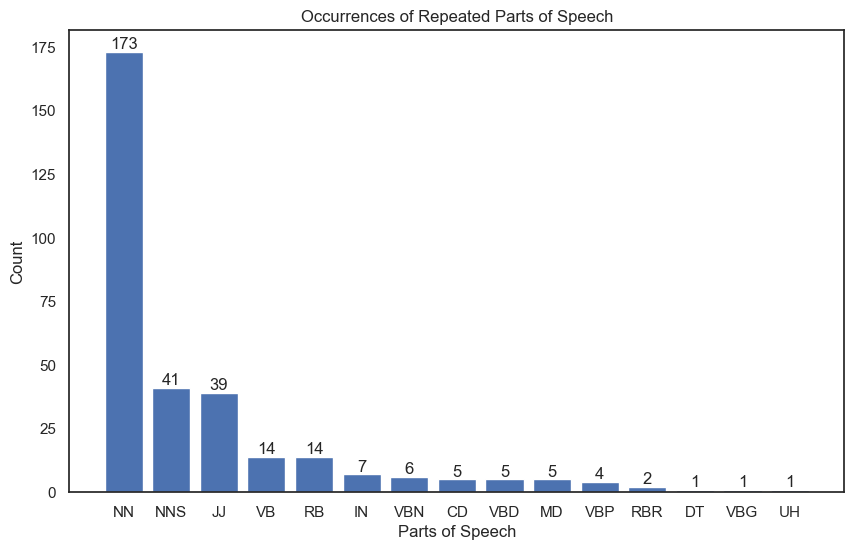

In [26]:
# Investigate most common overlapping parts of speech

repeated_pos_tags = [rep[1] for rep in repeated_pos] # get POS, discard the tokens
# repeated_pos
counts = Counter(repeated_pos_tags)
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

labels = [item[0] for item in sorted_counts]
counts = [item[1] for item in sorted_counts]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts)
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
             ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Parts of Speech')
plt.ylabel('Count')
plt.title('Occurrences of Repeated Parts of Speech')
plt.savefig('plots/overlapping_pos')

c:\users\kuba\onedrive\pulpit\studia\year 4\thesis\scripts\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\kuba\onedrive\pulpit\studia\year 4\thesis\scripts\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\users\kuba\onedrive\pulpit\studia\year 4\thesis\scripts\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\kuba\onedrive\pulpit\studia\year 4\thesis\scripts\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\users\kuba\onedrive\pulpit\studia\year 4\thesis\scripts\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=a

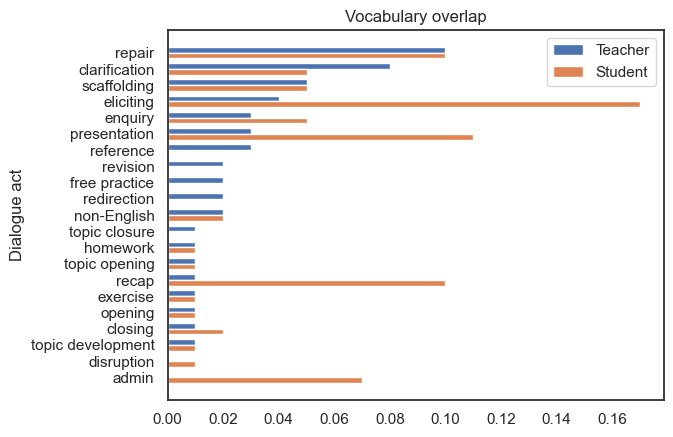

In [27]:
overlaps_total={}
plt.ion()
for seq_type in unique_seq_types:
    utts = chatrooms_dropped[chatrooms_dropped['seq.type'].str.contains(seq_type)]
    preceding_turns = chatrooms_all.iloc[utts.index-1]

    # Calculate vocabulary overlap
    overlaps_student = []
    overlaps_teacher = []
    for (utt, previous, role) in zip(utts['anonymised'], preceding_turns['anonymised'], utts['role']):
        if previous:
            utt_tokens = tokenize_and_preprocess(utt, True)

            previous_tokens = tokenize_and_preprocess(previous, True)

            if len(utt_tokens) > 0:
                if role == 'teacher':
                    intersect = set(previous_tokens).intersection(set(utt_tokens))
                    union = set(previous_tokens).union(set(utt_tokens))
                    
                    if len(union) > 0:
                        overlaps_teacher.append(len(intersect)/len(union))  # jaccard
                else:
                    intersect = set(previous_tokens).intersection(set(utt_tokens))
                    union = set(previous_tokens).union(set(utt_tokens))
                    
                    if len(union) > 0:
                        overlaps_student.append(len(intersect)/len(union))  # jaccard
    overlaps_total[seq_type] = (round(np.mean(overlaps_student),2)), (round(np.mean(overlaps_teacher),2))


overlaps_total= dict(sorted(overlaps_total.items(), key=lambda item: item[1][1]))
# overlaps_total
bar_width = 0.35
positions = np.arange(len(list(overlaps_total.keys())))
plt.barh(positions+bar_width/2, [value for tup_key, value in overlaps_total.values()], bar_width, label='Teacher')
plt.barh(positions-bar_width/2, [tup_key for tup_key, value in overlaps_total.values()], bar_width, label='Student')
plt.ylabel('Dialogue act')
plt.yticks(positions, list(overlaps_total.keys()))
plt.title('Vocabulary overlap')
plt.legend()
plt.show()
plt.savefig('plots/overlap_da.png', bbox_inches='tight')
# # list(overlaps_total.values())
# # list(overlaps_total.keys())

In [28]:
overlaps_total

{'admin': (0.07, 0.0),
 'disruption': (0.01, 0.0),
 'topic development': (0.01, 0.01),
 'closing': (0.02, 0.01),
 'opening': (0.01, 0.01),
 'exercise': (0.01, 0.01),
 'recap': (0.1, 0.01),
 'topic opening': (0.01, 0.01),
 'homework': (0.01, 0.01),
 'topic closure': (nan, 0.01),
 'non-English': (0.02, 0.02),
 'redirection': (0.0, 0.02),
 'free practice': (0.0, 0.02),
 'revision': (nan, 0.02),
 'reference': (nan, 0.03),
 'presentation': (0.11, 0.03),
 'enquiry': (0.05, 0.03),
 'eliciting': (0.17, 0.04),
 'scaffolding': (0.05, 0.05),
 'clarification': (0.05, 0.08),
 'repair': (0.1, 0.1)}

## Using readability metrics

In [29]:
student_flesch = {}
for student, contents in student_group:
    n_student_dialogues = len(contents)
    print(student)
    student_chats = []
    # The chats are already sorted by their timestamps, so I don't have to sort them
    for chat_num in contents['chat.num']:
        student_chats.append(chatrooms[chat_num-2])

    student_flesch[student] = []
    for chat in student_chats:
        fk_student_score = chat_flesch(chat)[2]
        student_flesch[student].append(fk_student_score)
    print(student_flesch[student])

'Uncomment when I want to run it'

In [30]:
student_flesch = json.load(open('flesch_scores.txt'))
student_flesch

{'student002': [3.858260383386586, 4.941664427526497, 3.3727384341637006],
 'student003': [2.8887956934337637,
  2.275402930402933,
  2.3336997822652954,
  5.191720626234989],
 'student004': [3.8021014492753658,
  2.55722215932677,
  3.2638533674339314,
  3.5981261042960284,
  3.4717365990764897,
  3.0129574900952996,
  4.384948491688899,
  3.4896037721499766,
  4.109099502487563,
  4.970505449754462,
  1.385942246578086,
  3.1831241238002796,
  2.6277289021485224,
  3.4978312537136063,
  4.260576308539946,
  4.1574615258677134,
  3.007930035650624,
  3.4580852390852392,
  2.349002466048418,
  2.841970149253733,
  4.292185792349727,
  2.608313705410481,
  2.8208030424645507,
  3.7680100808368984,
  4.135313147845064,
  2.416645962732918,
  2.780062198724927,
  5.0942584844258505],
 'student005': [4.954956709956708,
  4.452160353366349,
  4.332982456140353,
  1.9744705115672865,
  5.137781559863846,
  4.754981684981686],
 'student006': [2.663589743589746,
  5.935302512562814,
  6.728048

In [34]:

student_grade_over_time = {}
for student, contents in student_group:
    student_chat_nums = list(contents['chat.num'])
    n_chats = len(student_chat_nums)
    previous_chat_nums = [-1] + [student_chat_nums[i] for (i, chat) in enumerate(student_chat_nums[1:])]
    student_grade_over_time[student] = {
        'chat_index': student_chat_nums,
        'previous_chat_index': previous_chat_nums,
        'fk_prev': [0],
        'fk_curr': [],
        'MLU_prev': [0] + students_progress[student]['MLU'][:-1],
        'MLU_curr': students_progress[student]['MLU'],
        'AoA_prev': [0] + students_progress[student]['AoA'][:-1],
        'AoA_curr': students_progress[student]['AoA'],
        'WF_prev': [0] + students_progress[student]['WF'][:-1],
        'WF_curr': students_progress[student]['WF'],
        'TTR_prev': [0] + students_progress[student]['TTR'][:-1],
        'TTR_curr': students_progress[student]['TTR'],
        'utt_ratio_prev': [0] + students_progress[student]['utterances'][:-1],
        'utt_ratio_curr': students_progress[student]['utterances'],
        'words_ratio_prev': [0] + students_progress[student]['words'][:-1],
        'words_ratio_curr': students_progress[student]['words'],
        'timegaps': [0] + get_student_timegaps(student, contents),
        'fk_delta': [0],
        'MLU_delta': [0] + [students_progress[student]['MLU'][i] - students_progress[student]['MLU'][i-1] for i in range(1, n_chats)],
        'AOA_delta': [0] + [students_progress[student]['AoA'][i] - students_progress[student]['AoA'][i-1] for i in range(1, n_chats)],
        'WF_delta': [0] + [students_progress[student]['WF'][i] - students_progress[student]['WF'][i-1] for i in range(1, n_chats)],
        'TTR_delta': [0] + [students_progress[student]['TTR'][i] - students_progress[student]['TTR'][i-1] for i in range(1, n_chats)],
        'utt_ratio_delta': [0] + [students_progress[student]['utterances'][i] - students_progress[student]['utterances'][i-1] for i in range(1, n_chats)],
        'word_ratio_delta': [0] + [students_progress[student]['words'][i] - students_progress[student]['words'][i-1] for i in range(1, n_chats)],
        'student': [student]*len(student_chat_nums),
        # Here are tutor's moves for previous chats
        # , I decided to put them in the same array for simplicity (chat_index-2)
        "prev_scaffolding_ratio": [0] + [calc_scaffolding_proportion(chat) for chat in [
            chatrooms[num-2] for num in previous_chat_nums[1:]
        ]],
        "prev_overlaps": [0] + [tutor_overlaps_chat(chat) for chat in [
            chatrooms[num-2] for num in previous_chat_nums[1:]
        ]],
        "prev_complexity_match": [0] + [get_complexity_matching(chat) for chat in [
            chatrooms[num-2] for num in previous_chat_nums[1:]
        ]],
        'prev_teacher_grade': [0] + [chat_flesch(chat)[1] for chat in [
            chatrooms[num-2] for num in previous_chat_nums[1:]
        ]]
    }
    for i, chat in enumerate(student_chat_nums):
        fk_score = student_flesch[student][i]
        student_grade_over_time[student]['fk_curr'].append(fk_score)
        if i != 0:
            fk_previous = student_grade_over_time[student]['fk_curr'][i-1]
            student_grade_over_time[student]['fk_prev'].append(fk_previous)
            student_grade_over_time[student]['fk_delta'].append(fk_score-fk_previous)
student_grade_over_time

In [37]:
all_chat_pairs = []
for student in student_grade_over_time:
    df = pd.DataFrame.from_dict(student_grade_over_time[student])
    all_chat_pairs.append(df.loc[df['previous_chat_index'] != -1])
all_chat_pairs = pd.concat(all_chat_pairs)
all_chat_pairs

In [38]:
# # Now, I change the complexity match
all_chat_pairs['prev_complexity_match'] = [
    get_complexity_matching_MLU(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

# # Add new features - overlaps for turns, utts and POS, AoA complexity match

In [39]:
all_chat_pairs['prev_complexity_match_AoA'] = [
    get_complexity_matching_AoA(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

In [40]:
all_chat_pairs['prev_overlaps_turns'] = [
    tutor_overlaps_turns_chat(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

In [41]:
all_chat_pairs['prev_overlaps_turns_total'] = [
    either_overlaps_turns_chat(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

In [42]:
all_chat_pairs['prev_overlaps_pos'] = [
    pos_overlap_chat(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

In [43]:
all_chat_pairs['prev_overlaps'] = [
    tutor_overlaps_chat(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

In [44]:
all_chat_pairs['prev_overlaps_total'] = [
    total_overlaps_chat(chatrooms[index-2]) for index in all_chat_pairs['previous_chat_index']
]

#### In how many chats was the student's language more complex?

In [45]:
all_chat_pairs.loc[all_chat_pairs['prev_complexity_match_AoA']<0].shape

In [46]:
all_chat_pairs.loc[all_chat_pairs['prev_complexity_match']<0].shape

In [47]:
# Scale the complexity match
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

all_chat_pairs['prev_complexity_match'] = scaler.fit_transform(all_chat_pairs.loc[:,'prev_complexity_match'].values.reshape(-1, 1))
all_chat_pairs['prev_complexity_match_AoA'] = scaler.fit_transform(all_chat_pairs.loc[:,'prev_complexity_match_AoA'].values.reshape(-1, 1))

all_chat_pairs

In [48]:
all_chat_pairs = all_chat_pairs.reset_index().drop('index', axis=1)
all_chat_pairs

In [52]:
progressing_chat_pairs = all_chat_pairs.loc[all_chat_pairs['MLU_delta'] > 0]
progressing_chat_pairs

,chat_index,previous_chat_index,fk_prev,fk_curr,MLU_prev,MLU_curr,AoA_prev,AoA_curr,WF_prev,WF_curr,...,student,prev_scaffolding_ratio,prev_overlaps,prev_complexity_match,prev_teacher_grade,prev_complexity_match_AoA,prev_overlaps_turns,prev_overlaps_turns_total,prev_overlaps_pos,prev_overlaps_total
1,9,5,4.941664,3.372738,5.781250,6.775000,5.439215,4.756633,4993.576932,4580.688274,...,student002,0.186047,0.029909,0.926667,5.044098,-0.305868,0.025790,0.022289,0.240587,0.026585
3,12,8,2.275403,2.333700,7.687500,8.422222,4.569760,4.762170,4961.750446,3450.370591,...,student003,0.142857,0.030646,1.000000,5.841010,0.200733,0.057883,0.065632,0.373505,0.053817
4,16,12,2.333700,5.191721,8.422222,10.189189,4.762170,5.365991,3450.370591,3395.010541,...,student003,0.189655,0.054173,0.538202,4.646588,0.254973,0.053234,0.061760,0.375750,0.057373
6,7,6,2.557222,3.263853,11.285714,13.280000,4.474185,4.832131,3336.124497,2522.795892,...,student004,0.306667,0.015259,0.202939,4.066554,0.250827,0.054077,0.048659,0.406081,0.038274
8,11,10,3.598126,3.471737,10.016393,11.156863,4.120271,4.668175,2481.809089,2436.453353,...,student004,0.084337,0.015234,0.262344,4.556174,0.232985,0.046705,0.041960,0.355379,0.018474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,151,147,2.071173,2.338911,6.180328,6.370370,4.870955,4.409437,1877.234254,2826.954042,...,student015,0.214286,0.047078,0.324408,3.524738,0.167742,0.043142,0.051796,0.290699,0.122629
239,154,151,2.338911,2.554025,6.370370,7.695652,4.409437,4.038476,2826.954042,1548.033378,...,student015,0.148515,0.037353,0.175962,3.346195,0.291782,0.042282,0.058476,0.263553,0.049870
240,158,154,2.554025,4.121952,7.695652,8.595745,4.038476,4.343396,1548.033378,2268.545263,...,student015,0.320513,0.050887,0.234646,3.333710,0.463768,0.053413,0.054328,0.251246,0.057921
244,175,172,3.020862,3.722607,5.406780,6.743590,4.583071,5.295712,4111.132173,4545.637953,...,student015,0.333333,0.062422,0.316630,4.793455,0.476601,0.053026,0.048520,0.259925,0.062394


In [179]:
all_chat_pairs['timegaps'].corr(all_chat_pairs['MLU_delta'], method='pearson')

0.21983916595920927

In [239]:
stats.pearsonr(all_chat_pairs['timegaps'], all_chat_pairs['MLU_delta'])

PearsonRResult(statistic=0.21983916595920902, pvalue=0.0004879251501102787)

In [180]:
np.corrcoef(all_chat_pairs['timegaps'], all_chat_pairs['MLU_delta'])

array([[1.        , 0.21983917],
       [0.21983917, 1.        ]])

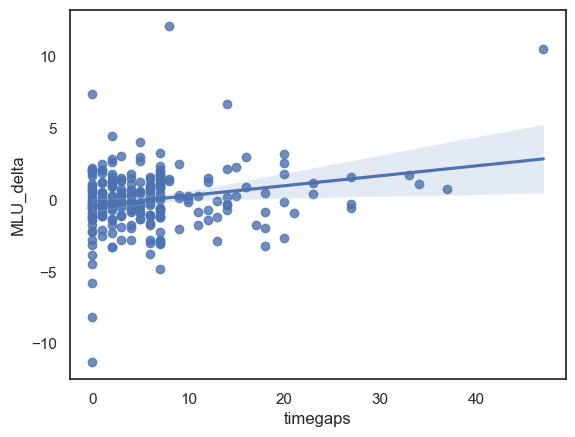

In [240]:
sns.regplot(data=all_chat_pairs, x="timegaps", y="MLU_delta").get_figure().savefig("plots/timegaps_reg.png")

No correlation.

In [55]:
seq_type_halves = {}
for seq_type in unique_seq_types:
    first_halves, second_halves = [], []
    for chat in chatrooms:
        chat1 = chat[:int(len(chat)/2)]
        chat2 = chat[int(len(chat)/2):]
        first_halves.append(len(chat1.loc[chat1['seq.type']==seq_type])/len(chat1))
        second_halves.append(len(chat2.loc[chat2['seq.type']==seq_type])/len(chat2))
    # print(seq_type, first_halves)
    seq_type_halves[seq_type] = (round(np.mean(first_halves),3), round(np.mean(second_halves),3))
seq_type_halves

In [56]:
seq_type_halves = {}
for seq_type in unique_seq_types:
    first_halves, second_halves = [], []
    for chat in chatrooms:
        chat1 = chat[:int(len(chat)/2)]
        chat2 = chat[int(len(chat)/2):]
        first_halves.append(len(chat1.loc[chat1['seq.type']==seq_type]))
        second_halves.append(len(chat2.loc[chat2['seq.type']==seq_type]))
    # print(seq_type, first_halves)
    seq_type_halves[seq_type] = (round(np.mean(first_halves),3), round(np.mean(second_halves),3))
seq_type_halves

{'clarification': (0.154, 0.154),
 'non-English': (0.385, 0.35),
 'topic development': (2.996, 1.012),
 'redirection': (0.035, 0.062),
 'closing': (0.0, 0.85),
 'opening': (0.977, 0.0),
 'reference': (0.038, 0.031),
 'free practice': (0.0, 0.0),
 'admin': (0.023, 0.023),
 'eliciting': (1.85, 2.565),
 'exercise': (0.738, 1.073),
 'presentation': (0.419, 1.285),
 'recap': (0.008, 0.073),
 'disruption': (0.246, 0.208),
 'revision': (0.046, 0.042),
 'topic opening': (2.004, 0.6),
 'scaffolding': (6.977, 9.342),
 'repair': (2.069, 2.046),
 'enquiry': (1.719, 1.654),
 'homework': (0.004, 0.115),
 'topic closure': (0.008, 0.008)}

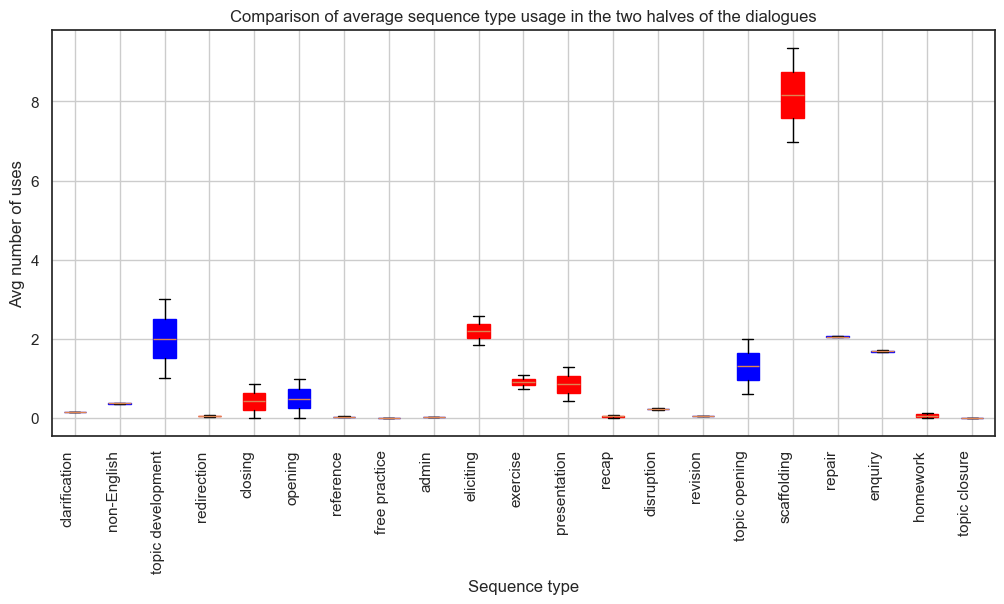

In [57]:
labels = list(seq_type_halves.keys())  # Extract labels
all_data = []
colors = []
for key, values in seq_type_halves.items():
    all_data.append(values)  # Collect individual data pairs
    colors.append('red' if values[1] > values[0] else 'blue')

# Create the boxplot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bp = plt.boxplot(all_data, patch_artist=True) 
for i, box in enumerate(bp['boxes']):
    box.set(color=colors[i])
# Labels and adjustments
plt.xticks(range(1, len(labels) + 1), labels, rotation=90, ha='right')  # Rotate labels for readability
plt.title('Comparison of average sequence type usage in the two halves of the dialogues')
plt.tight_layout()  # Prevent label overlapping
plt.grid(True)
plt.xlabel('Sequence type')
plt.ylabel('Avg number of uses')
plt.savefig('plots/seq_type_halves_new.png', bbox_inches='tight')
plt.show()

In [58]:
scaffolding_utts

,timestamp,user.id,role,turn.number,anonymised,edited,responding.to,sequence,seq.type,focus,resource,assessment,nWords
44,2019-11-17 12:29:31,teacher001,teacher,45,the the the the the the the the but only once ...,the the the the the the the the but only once ...,NaN,NaN,scaffolding,NaN,NaN,NaN,12
52,2019-11-17 12:33:25,teacher001,teacher,53,Thanks great example ..and nice that you know ...,Thanks great example ..and nice that you know ...,NaN,5c,scaffolding,NaN,NaN,NaN,23
73,2019-11-17 12:52:18,teacher001,teacher,74,Yes good point! So hotels/theatres/cinemas/mus...,Yes good point! So hotels/theatres/cinemas/mus...,NaN,8c,"scaffolding,eliciting",grammatical resource,NaN,NaN,23
75,2019-11-17 12:54:02,teacher001,teacher,76,Ah you live quite centrally - I'm jealous! (so...,Ah you live quite centrally - I'm jealous! (so...,NaN,8d,"scaffolding,eliciting",grammatical resource,NaN,NaN,30
77,2019-11-17 12:56:38,teacher001,teacher,78,Yeah that's it basically! so the 'someone' is ...,Yeah that's it basically! so the 'someone' is ...,NaN,8e,"scaffolding,eliciting",NaN,NaN,NaN,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41365,2021-06-18 10:00:42,teacher008,teacher,78,"Yes, someone who works down the mine. A coal m...","Yes, someone who works down the mine. A coal m...",NaN,NaN,scaffolding,"lexical resource,meaning",NaN,NaN,23
41366,2021-06-18 10:00:50,teacher008,teacher,79,"or a gold mine, if you're lucky :)","or a gold mine, if you're lucky :)",NaN,NaN,scaffolding,lexical resource,NaN,NaN,8
41369,2021-06-18 10:01:25,teacher008,teacher,82,"Yes, like in Donbass (at least there used to b...","Yes, like in Donbass (at least there used to b...",NaN,NaN,scaffolding,lexical resource,NaN,NaN,11
41373,2021-06-18 10:02:51,teacher008,teacher,86,No worries! There used to be a lot of mines in...,No worries! There used to be a lot of mines in...,84.0,NaN,scaffolding,"lexical resource,world knowledge",NaN,NaN,39


In [59]:
scaffolding_utts['tokens'] = scaffolding_utts['anonymised'].apply(tokenize_and_preprocess)

C:\Users\kuba\AppData\Local\Temp\ipykernel_6512\2288699206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaffolding_utts['tokens'] = scaffolding_utts['anonymised'].apply(tokenize_and_preprocess)


In [60]:
scaffolding_utts['tokens']

44       [the, the, the, the, the, the, the, the, but, ...
52       [thanks, great, example, and, nice, that, you,...
73       [yes, good, point, so, hotels, theatres, cinem...
75       [ah, you, live, quite, centrally, i, am, jealo...
77       [yeah, that, is, it, basically, so, the, someo...
                               ...                        
41365    [yes, someone, who, works, down, the, mine, a,...
41366             [or, a, gold, mine, if, you, are, lucky]
41369    [yes, like, in, donbass, at, least, there, use...
41373    [no, worries, there, used, to, be, a, lot, of,...
41422        [you, need, to, have, have, something, there]
Name: tokens, Length: 4650, dtype: object

In [61]:
all_results = []  # Store results from each n-gram calculation
for n in range(2, 5):
    ngrams = nltk.ngrams(sum(scaffolding_utts['tokens'], []), n)
    ngram_counts = nltk.Counter(ngrams)
    most_common_ngrams = ngram_counts.most_common(10)
    most_common_ngrams = [(' '.join(ngram), x) for ngram, x in most_common_ngrams]
    df_results = pd.DataFrame(most_common_ngrams, columns=[f'{n}-gram', f'{n}-gram count'])
    all_results.append(df_results)  

# Combine the DataFrames
df_combined = pd.concat(all_results, axis=1, ignore_index=True) 
df_combined

,0,1,2,3,4,5
0,it is,608,it is a,94,yes that is right,17
1,is a,281,you do not,56,or something like that,17
2,in the,270,by the way,56,you do not need,15
3,for example,237,a lot of,54,i do not know,14
4,e g,218,it is not,48,it is a bit,11
5,you can,207,but it is,42,i am going to,11
6,if you,191,i would say,41,yes that is it,10
7,do not,190,i do not,40,it is the same,10
8,you are,157,if you are,39,the stress is on,10
9,that is,154,yes that is,36,i do not think,10


In [62]:
seq_type_utts = {}
for seq_type in unique_seq_types:
    seq_type_utts[seq_type] = chatrooms_dropped[chatrooms_dropped['seq.type'].str.contains(seq_type)]

In [63]:
most_common_bigrams_per_seq_type = {}
most_common_trigrams_per_seq_type = {}
most_common_fourgrams_per_seq_type = {}

for key, value in seq_type_utts.items():
    tokens = value['anonymised'].apply(tokenize_and_preprocess)

    bigrams = nltk.ngrams(sum(tokens, []), 2)
    bigram_counts = Counter(bigrams)
    most_common_bigrams = bigram_counts.most_common(5)
    most_common_bigrams = ([(' '.join(ngram[0]), ngram[1]) for ngram in most_common_bigrams])

    print(f"{key}:\nTop 5 bigrams - {most_common_bigrams}\n")
    most_common_bigrams_per_seq_type[key] = most_common_bigrams

    trigrams = nltk.ngrams(sum(tokens, []), 3)
    trigram_counts = Counter(trigrams)
    most_common_trigrams = trigram_counts.most_common(5)
    most_common_trigrams = ([(' '.join(ngram[0]), ngram[1]) for ngram in most_common_trigrams])
    print(f"Top 5 trigrams - {most_common_trigrams}\n")
    most_common_trigrams_per_seq_type[key] = most_common_trigrams

    fourgrams = nltk.ngrams(sum(tokens, []), 4)
    fourgram_counts = Counter(fourgrams)
    most_common_fourgrams = fourgram_counts.most_common(5)
    most_common_fourgrams = ([(' '.join(ngram[0]), ngram[1]) for ngram in most_common_fourgrams])
    print(f"Top 5 fourgrams - {most_common_fourgrams}\n")
    most_common_fourgrams_per_seq_type[key] = most_common_fourgrams

clarification:
Top 5 bigrams - [('i mean', 26), ('sorry i', 7), ('i meant', 7), ('it is', 6), ('in the', 5)]

Top 5 trigrams - [('i mean the', 5), ('sorry i mean', 4), ('i mean a', 3), ('no i mean', 2), ('i mean with', 2)]

Top 5 fourgrams - [('i agree with you', 2), ('oh sorry i mean', 2), ('sorry i mean the', 2), ('no i mean what', 1), ('i mean what is', 1)]

non-English:
Top 5 bigrams - [('it is', 33), ('in russian', 27), ('is a', 13), ('i think', 11), ('you know', 9)]

Top 5 trigrams - [('i think it', 6), ('it is a', 4), ('do not know', 4), ('what is the', 4), ('in italian we', 4)]

Top 5 fourgrams - [('el club de la', 3), ('club de la comedian', 3), ('i do not know', 3), ('i think it is', 3), ('de la comedian i', 2)]

topic development:
Top 5 bigrams - [('it is', 111), ('do you', 107), ('are you', 85), ('i have', 67), ('in the', 62)]

Top 5 trigrams - [('how are you', 31), ('in the uk', 29), ('i do not', 25), ('do you think', 22), ('student s child', 18)]

Top 5 fourgrams - [('i d

In [64]:
most_common_ngrams_per_seq_type = {}
for (k,bi), (_,tri), (_, four) in zip(most_common_bigrams_per_seq_type.items(), most_common_trigrams_per_seq_type.items(), most_common_fourgrams_per_seq_type.items()):
    seq_type = k
    most_common_ngrams_per_seq_type[f"{seq_type} bigrams"] = bi
    most_common_ngrams_per_seq_type[f"{seq_type} trigrams"] = tri
    most_common_ngrams_per_seq_type[f"{seq_type} fourgrams"] = four
df = pd.DataFrame.from_dict(most_common_ngrams_per_seq_type).T
df

,0,1,2,3,4
clarification bigrams,"(i mean, 26)","(sorry i, 7)","(i meant, 7)","(it is, 6)","(in the, 5)"
clarification trigrams,"(i mean the, 5)","(sorry i mean, 4)","(i mean a, 3)","(no i mean, 2)","(i mean with, 2)"
clarification fourgrams,"(i agree with you, 2)","(oh sorry i mean, 2)","(sorry i mean the, 2)","(no i mean what, 1)","(i mean what is, 1)"
non-English bigrams,"(it is, 33)","(in russian, 27)","(is a, 13)","(i think, 11)","(you know, 9)"
non-English trigrams,"(i think it, 6)","(it is a, 4)","(do not know, 4)","(what is the, 4)","(in italian we, 4)"
...,...,...,...,...,...
homework trigrams,"(if you have, 15)","(i will send, 11)","(send you the, 9)","(have the time, 9)","(will send you, 9)"
homework fourgrams,"(i will send you, 9)","(if you have the, 7)","(you have the time, 7)","(have you had a, 6)","(you had a chance, 6)"
topic closure bigrams,"(it is, 3)","(about it, 2)","(to continue, 2)","(we can, 2)","(i see, 1)"
topic closure trigrams,"(i see it, 1)","(see it all, 1)","(it all makes, 1)","(all makes sense, 1)","(makes sense thank, 1)"


In [65]:
most_common_ngrams_per_seq_type

{'clarification bigrams': [('i mean', 26),
  ('sorry i', 7),
  ('i meant', 7),
  ('it is', 6),
  ('in the', 5)],
 'clarification trigrams': [('i mean the', 5),
  ('sorry i mean', 4),
  ('i mean a', 3),
  ('no i mean', 2),
  ('i mean with', 2)],
 'clarification fourgrams': [('i agree with you', 2),
  ('oh sorry i mean', 2),
  ('sorry i mean the', 2),
  ('no i mean what', 1),
  ('i mean what is', 1)],
 'non-English bigrams': [('it is', 33),
  ('in russian', 27),
  ('is a', 13),
  ('i think', 11),
  ('you know', 9)],
 'non-English trigrams': [('i think it', 6),
  ('it is a', 4),
  ('do not know', 4),
  ('what is the', 4),
  ('in italian we', 4)],
 'non-English fourgrams': [('el club de la', 3),
  ('club de la comedian', 3),
  ('i do not know', 3),
  ('i think it is', 3),
  ('de la comedian i', 2)],
 'topic development bigrams': [('it is', 111),
  ('do you', 107),
  ('are you', 85),
  ('i have', 67),
  ('in the', 62)],
 'topic development trigrams': [('how are you', 31),
  ('in the uk', 29

In [66]:
# Teachers scaffolding utts only X_scaffolding
X_scaffolding = []
for chat_index in all_chat_pairs['previous_chat_index']:
    if chat_index == -1: continue
    chat = chatrooms[chat_index-2]
    scaffolding_teacher_utts = chat[(chat['seq.type'].str.contains('scaffolding')) & (chat['role'] == 'teacher')]['anonymised']
    tokens = scaffolding_teacher_utts.apply(tokenize_and_preprocess)
    all_tokens = sum(tokens, [])
    tokens_joined = ' '.join(list(all_tokens))
    X_scaffolding.append(tokens_joined)
X_scaffolding = np.array(X_scaffolding)

In [67]:
X_scaffolding

array(['the the the the the the the the but only once obviously thanks great example and nice that you know you can just say the themes if you like and not always the river themes yes good point so hotels theatres cinemas museums galleries etc have the can you give me another example of one of these you have been to ah you live quite centrally i am jealous sort of and e g king s college barely s bank st mary s church do not have the can you see what they have in common yeah that is it basically so the someone is the important bit a name can you give me another example of a place like this',
       'ok right that is good i guess you can say people say or it is sometimes said that i am or i am said to be mature the last two are more formal good idea yes absolutely it is possible maybe we use it often for one occasion more generally we might say arrogant if you push yourself or somebody else it is like you want to go forward you know try again yes you are absolutely right if you need tone

In [68]:
# All teacher utterances X

X = []
for chat_index in all_chat_pairs['previous_chat_index']:
    if chat_index == -1: continue
    chat = chatrooms[chat_index-2]
    teacher_utts = chat[(chat['role'] == 'teacher')]['anonymised']
    tokens = teacher_utts.apply(tokenize_and_preprocess)
    all_tokens = sum(tokens, [])
    tokens_joined = ' '.join(list(all_tokens))
    X.append(tokens_joined)
X = np.array(X)

In [69]:
X.shape

(248,)

In [70]:
y = np.array(all_chat_pairs['MLU_delta'])
y.shape

(248,)

In [71]:
y

array([-1.71875000e+00,  9.93750000e-01, -2.01388889e-01,  7.34722222e-01,
        1.76696697e+00, -4.76190476e-02,  1.99428571e+00, -3.26360656e+00,
        1.14046930e+00, -5.79322638e+00,  1.60511364e+00,  1.18642241e+00,
       -9.09558379e-01,  1.04935164e+01, -1.13124638e+01,  1.83090909e+00,
        5.30303030e-01, -5.07177033e-01,  1.28094208e+00,  9.48994462e-01,
       -2.07515443e+00,  1.12383816e+00, -2.54344902e+00, -5.73565324e-01,
        4.45424403e+00, -4.47864128e+00,  2.06154161e+00,  4.16651841e-01,
        2.50012252e+00, -2.78511530e+00, -1.42777778e+00,  1.20875000e+01,
       -4.64367816e-01,  9.04718693e-01, -1.71442495e+00,  1.05555556e+00,
        4.61500975e-01,  2.08344198e-01,  4.04589309e+00, -3.23050847e+00,
       -3.21271930e-01, -1.04919908e+00,  1.63489409e+00, -2.15535445e+00,
        2.09926471e+00, -1.75000000e+00, -1.18311404e+00,  1.78561404e+00,
        6.53548387e-01, -1.40188172e+00,  1.87500000e+00,  7.39393939e+00,
       -8.15151515e+00, -

In [72]:
all_chat_pairs.loc[:,'MLU_delta']

0     -1.718750
1      0.993750
2     -0.201389
3      0.734722
4      1.766967
         ...   
243   -0.126554
244    1.336810
245   -2.822955
246    3.197012
247   -2.969499
Name: MLU_delta, Length: 248, dtype: float64

## NO test set

In [80]:
# no test set
cv_full = CountVectorizer(analyzer = 'word',ngram_range=(2,3))
X_cv = cv_full.fit_transform(X)

In [81]:
X_cv.shape

(248, 246133)

In [82]:
cv_full_cut = CountVectorizer(analyzer = 'word',ngram_range=(2,3), min_df=3)
X_cv_cut = cv_full_cut.fit_transform(X)
X_cv_cut.shape

(248, 17834)

In [83]:
reg_ngram_full = LinearRegression()
reg_ngram_full.fit(X_cv_cut, y)
feature_names_full = cv_full_cut.get_feature_names_out()

In [84]:
results_full = [(coef, ngram) for coef, ngram in zip(reg_ngram_full.coef_, feature_names_full)]
sorted_features_full = sorted(results_full, key=lambda x: x[0], reverse=True)

In [85]:
top_features_full = sorted_features_full[:20]

# Print top N-grams and their coefficients
print("Top Predictive N-grams overall (with coefficients):")
for coef, feature_name in top_features_full:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Predictive N-grams overall (with coefficients):
- ok so (Coef: 0.0872)
- you are (Coef: 0.0869)
- can you (Coef: 0.0866)
- more formal (Coef: 0.0853)
- let us (Coef: 0.0822)
- you see (Coef: 0.0781)
- they are (Coef: 0.0701)
- in the (Coef: 0.0675)
- right so (Coef: 0.0674)
- to think (Coef: 0.0654)
- and you (Coef: 0.0650)
- see the (Coef: 0.0622)
- you the (Coef: 0.0609)
- is an (Coef: 0.0585)
- going to (Coef: 0.0564)
- to do something (Coef: 0.0561)
- yes think (Coef: 0.0557)
- trying to (Coef: 0.0545)
- yes so (Coef: 0.0537)
- the word (Coef: 0.0529)
- is like (Coef: 0.0526)
- we could (Coef: 0.0521)
- in the future (Coef: 0.0521)
- ok yes (Coef: 0.0511)
- to do (Coef: 0.0508)
- the nhs (Coef: 0.0507)
- you will (Coef: 0.0500)
- well done (Coef: 0.0499)
- do something (Coef: 0.0499)
- hope that (Coef: 0.0498)
- idea of (Coef: 0.0496)
- lot about (Coef: 0.0492)
- what you mean (Coef: 0.0483)
- is right (Coef: 0.0471)
- the last (Coef: 0.0470)
- range of (Coef: 0.0470)
- the cae

In [187]:
for coef, feature_name in top_features_full[:20]:
    print(f"{feature_name} {coef:.4f}")

ok so 0.0872
you are 0.0869
can you 0.0866
more formal 0.0853
let us 0.0822
you see 0.0781
they are 0.0701
in the 0.0675
right so 0.0674
to think 0.0654
and you 0.0650
see the 0.0622
you the 0.0609
is an 0.0585
going to 0.0564
to do something 0.0561
yes think 0.0557
trying to 0.0545
yes so 0.0537
the word 0.0529


In [86]:
least_features_full = list(reversed(sorted_features_full[-50:]))

# Print top N-grams and their coefficients
print("Top Negatively Predictive N-grams overall (with coefficients):")
for coef, feature_name in least_features_full:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Negatively Predictive N-grams overall (with coefficients):
- that is (Coef: -0.1154)
- lots of (Coef: -0.1011)
- is definitely (Coef: -0.0749)
- are you (Coef: -0.0712)
- but you (Coef: -0.0688)
- present continuous (Coef: -0.0674)
- you should (Coef: -0.0643)
- not really (Coef: -0.0642)
- ok see (Coef: -0.0634)
- that the (Coef: -0.0628)
- did not (Coef: -0.0598)
- is very (Coef: -0.0592)
- ok thanks (Coef: -0.0581)
- is it (Coef: -0.0572)
- would say (Coef: -0.0560)
- there are (Coef: -0.0551)
- the more (Coef: -0.0543)
- it and (Coef: -0.0540)
- in my (Coef: -0.0536)
- oh really (Coef: -0.0515)
- to focus (Coef: -0.0494)
- at the moment (Coef: -0.0492)
- in the same (Coef: -0.0478)
- very good (Coef: -0.0477)
- the moment (Coef: -0.0462)
- that it (Coef: -0.0460)
- not have (Coef: -0.0455)
- guess that (Coef: -0.0452)
- live in (Coef: -0.0443)
- if you can (Coef: -0.0439)
- some good (Coef: -0.0438)
- you were (Coef: -0.0436)
- you say (Coef: -0.0426)
- planning to (Coef: -0.04

In [87]:
cv_scaffolding_full = CountVectorizer(analyzer = 'word',ngram_range=(2,3))
X_cv_scaffolding = cv_scaffolding_full.fit_transform(X_scaffolding)
X_cv_scaffolding.shape

(248, 81470)

In [88]:
cv_scaffolding_full_cut = CountVectorizer(analyzer = 'word',ngram_range=(2,3), min_df=3)
X_cv_scaffolding_cut = cv_scaffolding_full_cut.fit_transform(X_scaffolding)
X_cv_scaffolding_cut.shape

(248, 4077)

In [89]:

reg_ngram_scaff_full = LinearRegression()
reg_ngram_scaff_full.fit(X_cv_scaffolding_cut, y)

LinearRegression()

In [90]:
feature_names_scaff = cv_scaffolding_full_cut.get_feature_names_out()
results_scaff = [(coef, ngram) for coef, ngram in zip(reg_ngram_scaff_full.coef_, feature_names_scaff)]

sorted_features_scaff = sorted(results_scaff, key=lambda x: x[0], reverse=True)


In [91]:
with open("ngrams_scaff.txt", "w") as f:
    f.write(json.dumps(sorted_features_scaff))

In [92]:
top_features_scaff = sorted_features_scaff[:500]

# Print top N-grams and their coefficients
print("Top Predictive N-grams scaffolding (with coefficients):")
for coef, feature_name in top_features_scaff:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Predictive N-grams scaffolding (with coefficients):
- the snow (Coef: 1.7496)
- is called (Coef: 1.1564)
- the meaning (Coef: 0.5456)
- the people (Coef: 0.5269)
- that is (Coef: 0.5088)
- same with (Coef: 0.4774)
- could just (Coef: 0.4721)
- just say (Coef: 0.4678)
- is tricky (Coef: 0.4623)
- the meaning is (Coef: 0.4602)
- meaning is (Coef: 0.4600)
- etc good (Coef: 0.4587)
- is the one (Coef: 0.4574)
- does that (Coef: 0.4552)
- does that help (Coef: 0.4552)
- that help (Coef: 0.4552)
- is like (Coef: 0.4493)
- here so (Coef: 0.4071)
- need an adjective (Coef: 0.4045)
- you need an (Coef: 0.3743)
- the one you (Coef: 0.3639)
- you want (Coef: 0.3607)
- all the (Coef: 0.3521)
- one you (Coef: 0.3503)
- need an (Coef: 0.3470)
- an adjective (Coef: 0.3237)
- you could (Coef: 0.2593)
- the one (Coef: 0.2553)
- you re (Coef: 0.2367)
- more formal (Coef: 0.2343)
- not that (Coef: 0.2261)
- is an (Coef: 0.2025)
- is the (Coef: 0.1988)
- would not (Coef: 0.1919)
- of language (Coef: 0

In [93]:
least_features_scaff = list(reversed(sorted_features_scaff[-50:]))

print("Top Negatively Predictive N-grams scaffolding (with coefficients):")
for coef, feature_name in least_features_scaff:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Negatively Predictive N-grams scaffolding (with coefficients):
- some of (Coef: -0.3746)
- form of (Coef: -0.3409)
- is very (Coef: -0.3347)
- non fiction (Coef: -0.3307)
- if you can (Coef: -0.3168)
- it is called (Coef: -0.3057)
- not really (Coef: -0.2878)
- mean that (Coef: -0.2853)
- not mean (Coef: -0.2763)
- as in (Coef: -0.2702)
- good but (Coef: -0.2676)
- the second (Coef: -0.2635)
- you would (Coef: -0.2625)
- might not (Coef: -0.2618)
- used to (Coef: -0.2568)
- what is (Coef: -0.2519)
- that some (Coef: -0.2443)
- it it (Coef: -0.2435)
- form of the (Coef: -0.2376)
- to it (Coef: -0.2322)
- if you (Coef: -0.2296)
- be useful (Coef: -0.2246)
- is if you (Coef: -0.2166)
- of something (Coef: -0.2154)
- is made (Coef: -0.2127)
- with other (Coef: -0.2115)
- it might (Coef: -0.2088)
- say the (Coef: -0.2088)
- look up (Coef: -0.2087)
- and this (Coef: -0.2075)
- got to (Coef: -0.2074)
- not have (Coef: -0.2067)
- is if (Coef: -0.2035)
- the dictionary (Coef: -0.2027)
- the

In [94]:
previous_chats = [chatrooms[chat_index-2] for chat_index in all_chat_pairs['previous_chat_index']]
len(previous_chats)

248

In [95]:
previous_chats[0]

,timestamp,user.id,role,turn.number,anonymised,edited,responding.to,sequence,seq.type,focus,resource,assessment,nWords
0,2019-11-17 12:00:08,teacher001,teacher,1,"Hi <STUDENT>, hope I didn't get you up too early!","Hi <STUDENT>, hope I didn't get you up too early!",NaN,1.0,opening,NaN,NaN,NaN,10
1,2019-11-17 12:01:08,student002,student,2,"Don't worry, my exam is on next Saturday, so I...","Don't worry, my exam is next Saturday, so I sh...",NaN,NaN,NaN,NaN,NaN,NaN,14
2,2019-11-17 12:01:37,teacher001,teacher,3,"Ah OK, so good practice then...is that an IELT...","Ah OK, so good practice then...is that an IELT...",NaN,2.0,topic opening,NaN,NaN,NaN,10
3,2019-11-17 12:01:52,student002,student,4,Exactly.,Exactly.,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2019-11-17 12:02:11,teacher001,teacher,5,I've lost track of how many you've done,I've lost track of how many you've done,NaN,NaN,NaN,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2019-11-17 13:01:33,teacher001,teacher,88,OK thank's <STUDENT> -we'll leave it there ok?...,OK thank's <STUDENT> -we'll leave it there ok?...,NaN,9.0,closing,NaN,NaN,NaN,14
88,2019-11-17 13:01:51,student002,student,89,"Okay, thank you!!","Okay, thank you!!",NaN,NaN,NaN,NaN,NaN,NaN,3
89,2019-11-17 13:02:08,teacher001,teacher,90,I'll be in touch - feel free to send me an ema...,I'll be in touch - feel free to send me an ema...,NaN,NaN,NaN,NaN,NaN,NaN,13
90,2019-11-17 13:02:27,student002,student,91,"Sure, see you.","Sure, see you.",NaN,NaN,NaN,NaN,NaN,NaN,3


In [96]:
features_df = pd.DataFrame.from_dict({
    "scaffolding_ratio": all_chat_pairs['prev_scaffolding_ratio'],
    "overlaps_teacher": all_chat_pairs['prev_overlaps'],
    "overlaps_total": all_chat_pairs['prev_overlaps_total'],
    "overlaps_teacher_turns": all_chat_pairs['prev_overlaps_turns'],
    "overlaps_total_turns": all_chat_pairs['prev_overlaps_turns_total'],
    'complexity_match_MLU': all_chat_pairs['prev_complexity_match'],
    'complexity_match_AoA': all_chat_pairs['prev_complexity_match_AoA'],
    'overlaps_pos': all_chat_pairs['prev_overlaps_pos']
})
features_df

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos
0,0.096154,0.037348,0.140432,0.054235,0.062117,0.420259,-0.197223,0.358325
1,0.186047,0.029909,0.026585,0.025790,0.022289,0.926667,-0.305868,0.240587
2,0.235294,0.001502,0.041086,0.029962,0.059715,0.639528,0.086148,0.339065
3,0.142857,0.030646,0.053817,0.057883,0.065632,1.000000,0.200733,0.373505
4,0.189655,0.054173,0.057373,0.053234,0.061760,0.538202,0.254973,0.375750
...,...,...,...,...,...,...,...,...
243,0.377193,0.054056,0.072390,0.059713,0.070020,0.402818,0.709275,0.262323
244,0.333333,0.062422,0.062394,0.053026,0.048520,0.316630,0.476601,0.259925
245,0.083333,0.055561,0.086593,0.042665,0.060525,0.202289,-0.013851,0.304500
246,0.142857,0.043723,0.061475,0.060172,0.050853,0.304371,0.497815,0.251567


In [97]:
# features_df.loc[features_df['complexity_match']<0, 'complexity_match'] = 0  # for better scaling
# features_df.loc[:,'complexity_match_MLU'] = abs(features_df.loc[:,'complexity_match_MLU'])
# features_df.loc[:,'complexity_match_AoA'] = abs(features_df.loc[:,'complexity_match_AoA'])
# features_df.loc[:,'complexity_match_AoA']

In [98]:
features_df.loc[:,'complexity_match_MLU'] = 1-features_df.loc[:,'complexity_match_MLU']  # so that the higher it is, the bigger the match
features_df.loc[:,'complexity_match_AoA'] = 1-features_df.loc[:,'complexity_match_AoA']  # so that the higher it is, the bigger the match
features_df.loc[:,'complexity_match_AoA']

0      1.197223
1      1.305868
2      0.913852
3      0.799267
4      0.745027
         ...   
243    0.290725
244    0.523399
245    1.013851
246    0.502185
247    0.857427
Name: complexity_match_AoA, Length: 248, dtype: float64

In [99]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['scaffolding_ratio', 'overlaps_teacher', 'overlaps_total', 'overlaps_teacher_turns', 'overlaps_total_turns', 'overlaps_pos']
features_df[features_to_scale] = scaler.fit_transform(features_df[features_to_scale])
# df_scaled = pd.DataFrame(df_scaled, columns=['scaffolding_ratio', 'overlaps_teacher', 'overlaps_total', 'complexity_match'])
df_scaled = features_df
df_scaled

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos
0,0.184911,0.338496,0.206478,0.544426,0.547261,0.579741,1.197223,0.596149
1,0.357782,0.269518,0.032573,0.174373,0.096609,0.073333,1.305868,0.249982
2,0.452489,0.006085,0.054723,0.228644,0.520085,0.360472,0.913852,0.539522
3,0.274725,0.276350,0.074170,0.591885,0.587033,0.000000,0.799267,0.640782
4,0.364721,0.494526,0.079602,0.531406,0.543219,0.461798,0.745027,0.647381
...,...,...,...,...,...,...,...,...
243,0.725371,0.493435,0.102541,0.615697,0.636681,0.597182,0.290725,0.313889
244,0.641026,0.571018,0.087272,0.528700,0.393414,0.683370,0.523399,0.306840
245,0.160256,0.507396,0.124238,0.393904,0.529249,0.797711,1.013851,0.437895
246,0.274725,0.397619,0.085868,0.621669,0.419807,0.695629,0.502185,0.282265


In [100]:
df_scaled.shape

(248, 8)

# This is for the values split between test and train sets

In [101]:
X_features_train, X_features_test, y_train, y_test = train_test_split(features_df, y, test_size=0.2)

In [102]:
X_features_train.shape

(198, 8)

In [103]:
from sklearn import metrics
reg_features = LinearRegression()
reg_features.fit(X_features_train, y_train)
Y_features_pred = reg_features.predict(X_features_test)

In [104]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, Y_features_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, Y_features_pred))
print('R2:', metrics.r2_score(y_test, Y_features_pred))

# Print the coefficients and intercept
print('Coefficients:', reg_features.coef_)
print('Intercept:', reg_features.intercept_)

Mean Absolute Error: 1.4302436617779068
Mean Squared Error: 5.242181293616742
R2: -0.4038178491838358
Coefficients: [ 1.51469843 -0.92752435 -0.5937615   2.27132638 -1.86128017 -3.31337378
 -0.26466775 -2.27973179]
Intercept: 3.0035235455605402


## From now on, we don't split

In [105]:
df_scaled['delta'] = y
df_scaled

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos,delta
0,0.184911,0.338496,0.206478,0.544426,0.547261,0.579741,1.197223,0.596149,-1.718750
1,0.357782,0.269518,0.032573,0.174373,0.096609,0.073333,1.305868,0.249982,0.993750
2,0.452489,0.006085,0.054723,0.228644,0.520085,0.360472,0.913852,0.539522,-0.201389
3,0.274725,0.276350,0.074170,0.591885,0.587033,0.000000,0.799267,0.640782,0.734722
4,0.364721,0.494526,0.079602,0.531406,0.543219,0.461798,0.745027,0.647381,1.766967
...,...,...,...,...,...,...,...,...,...
243,0.725371,0.493435,0.102541,0.615697,0.636681,0.597182,0.290725,0.313889,-0.126554
244,0.641026,0.571018,0.087272,0.528700,0.393414,0.683370,0.523399,0.306840,1.336810
245,0.160256,0.507396,0.124238,0.393904,0.529249,0.797711,1.013851,0.437895,-2.822955
246,0.274725,0.397619,0.085868,0.621669,0.419807,0.695629,0.502185,0.282265,3.197012


<Axes: xlabel='overlaps_total', ylabel='delta'>

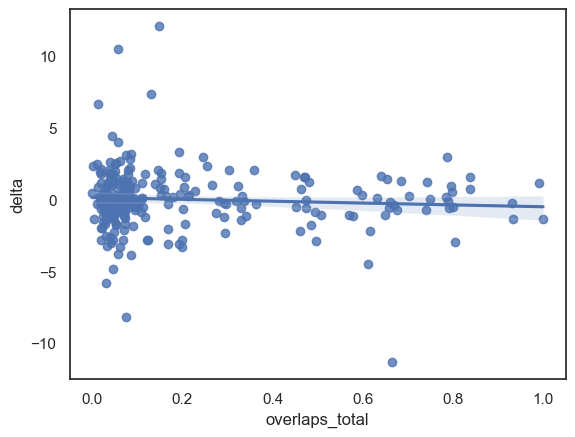

In [106]:
sns.regplot(data=df_scaled, x="overlaps_total", y="delta")

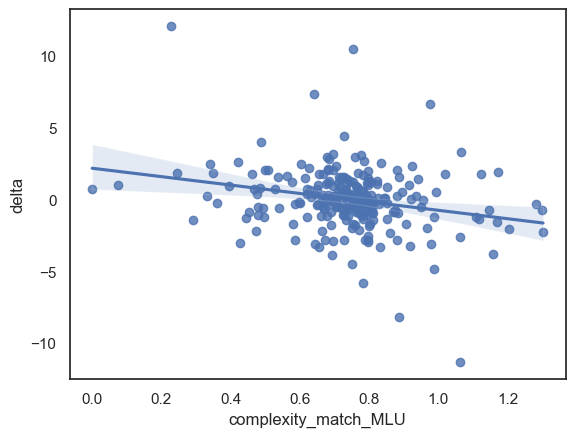

In [221]:
plot=sns.regplot(data=df_scaled, x="complexity_match_MLU", y="delta")
fig = plot.get_figure()
fig.savefig("plots/match_mlu_ref.png")

<Axes: xlabel='scaffolding_ratio', ylabel='delta'>

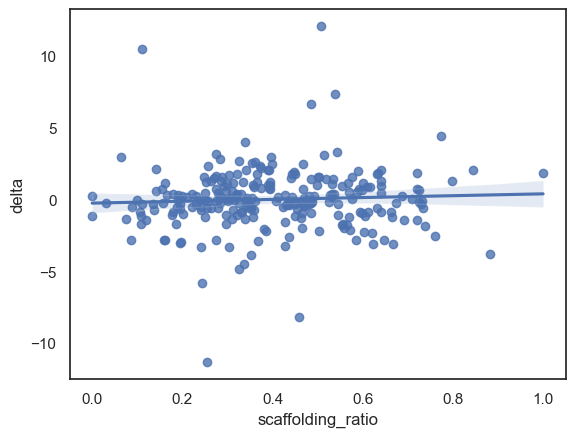

In [108]:
sns.regplot(data=df_scaled, x="scaffolding_ratio", y="delta")

Based on the results, we can see that matching the level does predict the progress, and the teacher using an even easier language than the student, predicts it even more.

<Axes: xlabel='overlaps_teacher', ylabel='delta'>

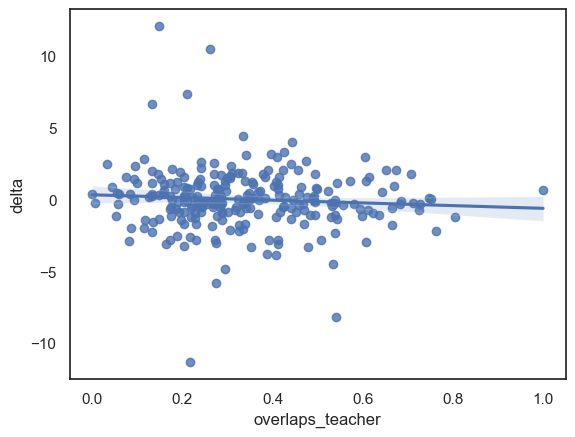

In [109]:
sns.regplot(data=df_scaled, x="overlaps_teacher", y="delta")

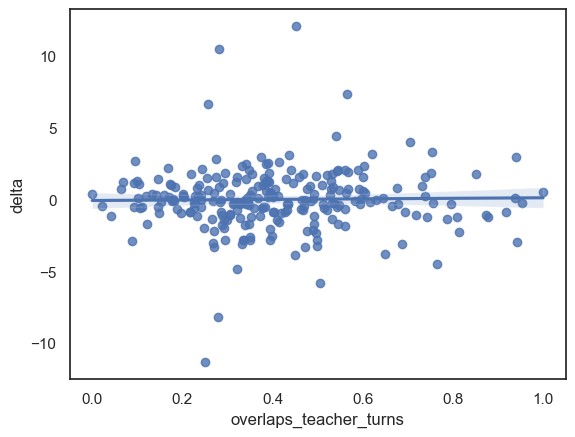

In [222]:
plot = sns.regplot(data=df_scaled, x="overlaps_teacher_turns", y="delta")
fig = plot.get_figure()
fig.savefig("plots/overlaps_teacher_reg.png")

<Axes: xlabel='overlaps_total_turns', ylabel='delta'>

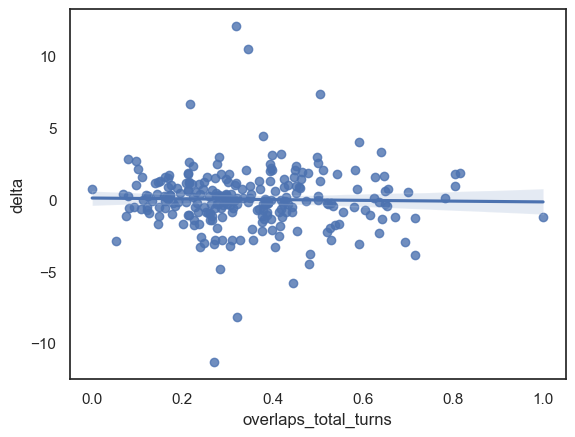

In [111]:
sns.regplot(data=df_scaled, x="overlaps_total_turns", y="delta")

<Axes: xlabel='complexity_match_AoA', ylabel='delta'>

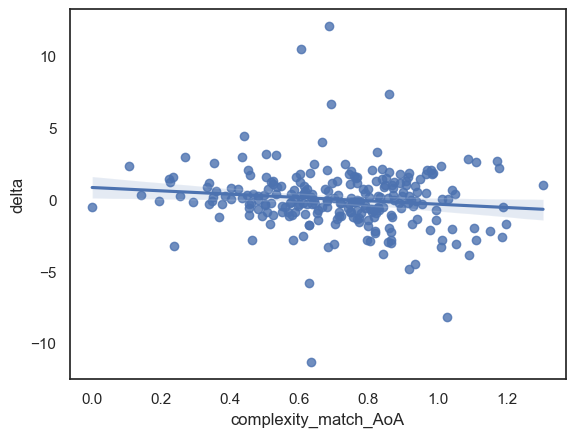

In [112]:
sns.regplot(data=df_scaled, x="complexity_match_AoA", y="delta")

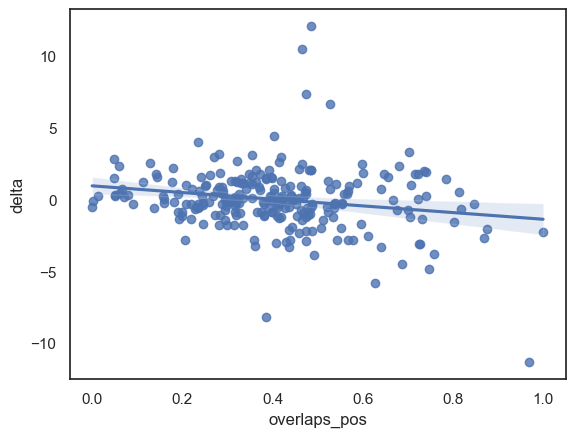

In [223]:
sns.regplot(data=df_scaled, x="overlaps_pos", y="delta").get_figure().savefig("plots/overlap_pos_reg")

In [114]:
# import statsmodels.formula.api as smf
# model = smf.ols('delta ~ teacher_easy + complexity_match + scaffolding_ratio + overlaps', data=features_df)
# results = model.fit()
# print(results.summary())

import statsmodels.formula.api as smf
model = smf.ols(f"delta ~{' + '.join(list(df_scaled)[:-1])}", data=df_scaled)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  delta   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.309
Date:                Fri, 19 Apr 2024   Prob (F-statistic):            0.00132
Time:                        16:34:21   Log-Likelihood:                -531.39
No. Observations:                 248   AIC:                             1081.
Df Residuals:                     239   BIC:                             1112.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

In [202]:
print(results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &      delta       & \textbf{  R-squared:         } &     0.100   \\
\textbf{Model:}                   &       OLS        & \textbf{  Adj. R-squared:    } &     0.070   \\
\textbf{Method:}                  &  Least Squares   & \textbf{  F-statistic:       } &     3.309   \\
\textbf{Date:}                    & Fri, 19 Apr 2024 & \textbf{  Prob (F-statistic):} &  0.00132    \\
\textbf{Time:}                    &     22:24:34     & \textbf{  Log-Likelihood:    } &   -531.39   \\
\textbf{No. Observations:}        &         248      & \textbf{  AIC:               } &     1081.   \\
\textbf{Df Residuals:}            &         239      & \textbf{  BIC:               } &     1112.   \\
\textbf{Df Model:}                &           8      & \textbf{                     } &             \\
\textbf{Covariance Type:}         &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\

In [213]:

for key, coeff, p in zip(list(results.pvalues.keys()), results.params.values, results.pvalues.values):
    print(f"{key} & {coeff:.4f} & {p:.4f}\\\\")

Intercept & 2.6540 & 0.0027\\
scaffolding_ratio & 1.0001 & 0.2000\\
overlaps_teacher & -0.9950 & 0.2967\\
overlaps_total & -0.4947 & 0.4120\\
overlaps_teacher_turns & 1.4286 & 0.1689\\
overlaps_total_turns & -0.8914 & 0.4748\\
complexity_match_MLU & -2.4618 & 0.0043\\
complexity_match_AoA & -0.6682 & 0.3411\\
overlaps_pos & -1.3931 & 0.1563\\


In [115]:
all_chat_pairs

,chat_index,previous_chat_index,fk_prev,fk_curr,MLU_prev,MLU_curr,AoA_prev,AoA_curr,WF_prev,WF_curr,...,student,prev_scaffolding_ratio,prev_overlaps,prev_complexity_match,prev_teacher_grade,prev_complexity_match_AoA,prev_overlaps_turns,prev_overlaps_turns_total,prev_overlaps_pos,prev_overlaps_total
0,5,2,3.858260,4.941664,7.500000,5.781250,4.793650,5.439215,2931.982976,4993.576932,...,student002,0.096154,0.037348,0.420259,3.478470,-0.197223,0.054235,0.062117,0.358325,0.140432
1,9,5,4.941664,3.372738,5.781250,6.775000,5.439215,4.756633,4993.576932,4580.688274,...,student002,0.186047,0.029909,0.926667,5.044098,-0.305868,0.025790,0.022289,0.240587,0.026585
2,8,4,2.888796,2.275403,7.888889,7.687500,4.891089,4.569760,3699.349007,4961.750446,...,student003,0.235294,0.001502,0.639528,5.769109,0.086148,0.029962,0.059715,0.339065,0.041086
3,12,8,2.275403,2.333700,7.687500,8.422222,4.569760,4.762170,4961.750446,3450.370591,...,student003,0.142857,0.030646,1.000000,5.841010,0.200733,0.057883,0.065632,0.373505,0.053817
4,16,12,2.333700,5.191721,8.422222,10.189189,4.762170,5.365991,3450.370591,3395.010541,...,student003,0.189655,0.054173,0.538202,4.646588,0.254973,0.053234,0.061760,0.375750,0.057373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,172,166,2.765443,3.020862,5.533333,5.406780,3.907323,4.583071,1586.310152,4111.132173,...,student015,0.377193,0.054056,0.402818,4.202969,0.709275,0.059713,0.070020,0.262323,0.072390
244,175,172,3.020862,3.722607,5.406780,6.743590,4.583071,5.295712,4111.132173,4545.637953,...,student015,0.333333,0.062422,0.316630,4.793455,0.476601,0.053026,0.048520,0.259925,0.062394
245,179,175,3.722607,1.531943,6.743590,3.920635,5.295712,4.019013,4545.637953,3679.601398,...,student015,0.083333,0.055561,0.202289,3.001018,-0.013851,0.042665,0.060525,0.304500,0.086593
246,194,179,1.531943,3.229642,3.920635,7.117647,4.019013,4.249758,3679.601398,5112.104437,...,student015,0.142857,0.043723,0.304371,2.712571,0.497815,0.060172,0.050853,0.251567,0.061475


## I'll check it all for dialogue halves, maybe some sensible correlation there?

In [116]:
# first half - features (ngrams, scaff_ratio, overlaps, complex match)
# second half - MLU delta between second and first half

all_chat_halves = {
    "scaffolding_ratio": [],
    "overlaps_teacher": [],
    "overlaps_total": [],
    "overlaps_teacher_turns": [],
    "overlaps_total_turns": [],
    'complexity_match_MLU': [],
    'complexity_match_AoA': [],
    'overlaps_pos': [],
    'MLU_delta': []
}
for chat in chatrooms:
    chat1 = chat[:int(len(chat)/2)]
    chat2 = chat[int(len(chat)/2):]

    all_chat_halves['scaffolding_ratio'].append(calc_scaffolding_proportion(chat1))
    all_chat_halves['overlaps_total'].append(total_overlaps_chat(chat1))
    all_chat_halves['overlaps_teacher'].append(tutor_overlaps_chat(chat1))
    all_chat_halves['overlaps_total_turns'].append(either_overlaps_turns_chat(chat1))
    all_chat_halves['overlaps_teacher_turns'].append(tutor_overlaps_turns_chat(chat1))
    all_chat_halves['overlaps_pos'].append(total_overlaps_chat(chat1))
    all_chat_halves['complexity_match_MLU'].append(get_complexity_matching_MLU(chat1))
    all_chat_halves['complexity_match_AoA'].append(get_complexity_matching_AoA(chat1))
    all_chat_halves['MLU_delta'].append(chat_MLU(chat2)[2] - chat_MLU(chat1)[2])



In [119]:
all_chat_halves

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos,MLU_delta
0,0.041667,0.051677,0.065186,0.071928,0.079430,7.761364,-0.166285,0.065186,1.414141
1,0.071429,0.023722,0.090970,0.048748,0.052626,2.865764,0.437363,0.090970,-5.628476
2,0.280000,0.000000,0.077053,0.018376,0.091943,11.918261,0.241691,0.077053,-3.339921
3,0.150000,0.028070,0.027413,0.035556,0.034316,12.538235,-0.910475,0.027413,2.921569
4,0.250000,0.008711,0.058308,0.045119,0.040351,4.280303,0.786268,0.058308,0.663636
...,...,...,...,...,...,...,...,...,...
255,0.148148,0.027160,0.096807,0.021994,0.043973,6.488889,0.837991,0.096807,4.399283
256,0.142857,0.075595,0.105146,0.075625,0.063311,-1.049689,-0.133375,0.105146,-6.144928
257,0.114286,0.004545,0.011190,0.035902,0.039102,3.364286,0.293746,0.011190,-1.664286
258,0.243243,0.064986,0.328665,0.041848,0.040829,4.864364,0.815612,0.328665,-1.909544


In [120]:
halves_df = pd.DataFrame.from_dict(all_chat_halves)
halves_df

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos,MLU_delta
0,0.041667,0.051677,0.065186,0.071928,0.079430,7.761364,-0.166285,0.065186,1.414141
1,0.071429,0.023722,0.090970,0.048748,0.052626,2.865764,0.437363,0.090970,-5.628476
2,0.280000,0.000000,0.077053,0.018376,0.091943,11.918261,0.241691,0.077053,-3.339921
3,0.150000,0.028070,0.027413,0.035556,0.034316,12.538235,-0.910475,0.027413,2.921569
4,0.250000,0.008711,0.058308,0.045119,0.040351,4.280303,0.786268,0.058308,0.663636
...,...,...,...,...,...,...,...,...,...
255,0.148148,0.027160,0.096807,0.021994,0.043973,6.488889,0.837991,0.096807,4.399283
256,0.142857,0.075595,0.105146,0.075625,0.063311,-1.049689,-0.133375,0.105146,-6.144928
257,0.114286,0.004545,0.011190,0.035902,0.039102,3.364286,0.293746,0.011190,-1.664286
258,0.243243,0.064986,0.328665,0.041848,0.040829,4.864364,0.815612,0.328665,-1.909544


In [121]:

scaler_complex_halves = MaxAbsScaler()

halves_df['complexity_match_MLU'] = scaler_complex_halves.fit_transform(halves_df.loc[:,'complexity_match_MLU'].values.reshape(-1, 1))
halves_df['complexity_match_AoA'] = scaler_complex_halves.fit_transform(halves_df.loc[:,'complexity_match_AoA'].values.reshape(-1, 1))

halves_df

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos,MLU_delta
0,0.041667,0.051677,0.065186,0.071928,0.079430,0.483072,-0.071017,0.065186,1.414141
1,0.071429,0.023722,0.090970,0.048748,0.052626,0.178367,0.186788,0.090970,-5.628476
2,0.280000,0.000000,0.077053,0.018376,0.091943,0.741800,0.103221,0.077053,-3.339921
3,0.150000,0.028070,0.027413,0.035556,0.034316,0.780388,-0.388844,0.027413,2.921569
4,0.250000,0.008711,0.058308,0.045119,0.040351,0.266409,0.335798,0.058308,0.663636
...,...,...,...,...,...,...,...,...,...
255,0.148148,0.027160,0.096807,0.021994,0.043973,0.403873,0.357888,0.096807,4.399283
256,0.142857,0.075595,0.105146,0.075625,0.063311,-0.065333,-0.056961,0.105146,-6.144928
257,0.114286,0.004545,0.011190,0.035902,0.039102,0.209395,0.125452,0.011190,-1.664286
258,0.243243,0.064986,0.328665,0.041848,0.040829,0.302761,0.348330,0.328665,-1.909544


In [122]:
# halves_df.loc[halves_df['complexity_match']<0, 'complexity_match'] = 0  # for better scaling
halves_df.loc[:,'complexity_match_MLU'] = 1-halves_df.loc[:,'complexity_match_MLU']
halves_df.loc[:,'complexity_match_AoA'] = 1-halves_df.loc[:,'complexity_match_AoA']

In [123]:
scaler_min_max_halves = MinMaxScaler()
features_to_scale_halves = ['scaffolding_ratio', 'overlaps_teacher', 'overlaps_total', 'overlaps_teacher_turns', 'overlaps_total_turns', 'overlaps_pos']
halves_df[features_to_scale_halves] = scaler.fit_transform(halves_df[features_to_scale_halves])
halves_df_scaled = halves_df
halves_df_scaled

,scaffolding_ratio,overlaps_teacher,overlaps_total,overlaps_teacher_turns,overlaps_total_turns,complexity_match_MLU,complexity_match_AoA,overlaps_pos,MLU_delta
0,0.075521,0.303663,0.079444,0.558599,0.740150,0.516928,1.071017,0.079444,1.414141
1,0.129464,0.139395,0.114798,0.354603,0.460773,0.821633,0.813212,0.114798,-5.628476
2,0.507500,0.000000,0.095716,0.087308,0.870578,0.258200,0.896779,0.095716,-3.339921
3,0.271875,0.164947,0.027650,0.238500,0.269932,0.219612,1.388844,0.027650,2.921569
4,0.453125,0.051190,0.070012,0.322659,0.332838,0.733591,0.664202,0.070012,0.663636
...,...,...,...,...,...,...,...,...,...
255,0.268519,0.159597,0.122801,0.119153,0.370589,0.596127,0.642112,0.122801,4.399283
256,0.258929,0.444215,0.134236,0.591138,0.572145,1.065333,1.056961,0.134236,-6.144928
257,0.207143,0.026710,0.005406,0.241545,0.319818,0.790605,0.874548,0.005406,-1.664286
258,0.440878,0.381875,0.440722,0.293880,0.337814,0.697239,0.651670,0.440722,-1.909544


In [225]:
model_halves = smf.ols(f"MLU_delta ~{' + '.join(list(halves_df_scaled)[:-1])}", data=halves_df_scaled)
results_halves = model_halves.fit()
print(results_halves.summary())

                            OLS Regression Results                            
Dep. Variable:              MLU_delta   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     8.944
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           7.65e-10
Time:                        23:58:00   Log-Likelihood:                -602.82
No. Observations:                 260   AIC:                             1222.
Df Residuals:                     252   BIC:                             1250.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [226]:
for key, coeff, p in zip(list(results_halves.pvalues.keys()), results_halves.params.values, results_halves.pvalues.values):
    print(f"{key} & {coeff:.4f} & {p:.4f}\\\\")

Intercept & 4.3834 & 0.0000\\
scaffolding_ratio & -0.5220 & 0.5115\\
overlaps_teacher & 0.5659 & 0.6768\\
overlaps_total & -0.4837 & 0.1603\\
overlaps_teacher_turns & 1.3866 & 0.2839\\
overlaps_total_turns & -2.5153 & 0.0330\\
complexity_match_MLU & -4.8930 & 0.0000\\
complexity_match_AoA & -1.2617 & 0.0578\\
overlaps_pos & -0.4837 & 0.1603\\


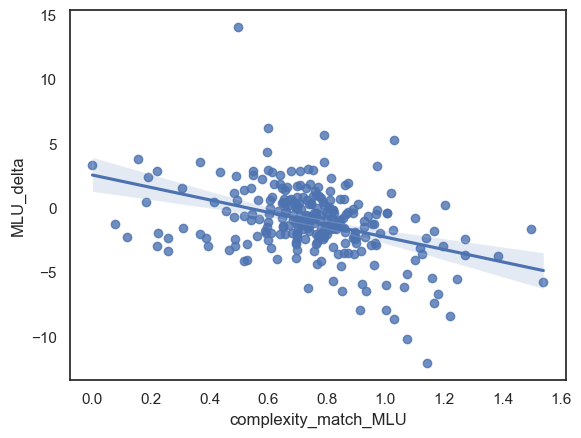

In [228]:
sns.regplot(data=halves_df_scaled,x='complexity_match_MLU',y='MLU_delta').get_figure().savefig("plots/match_mlu_halves_reg.png")

In [ ]:
sns.regplot(data=halves_df_scaled,x='complexity_match_MLU',y='MLU_delta').get_figure().savefig("plots/match_mlu_halves_reg.png")

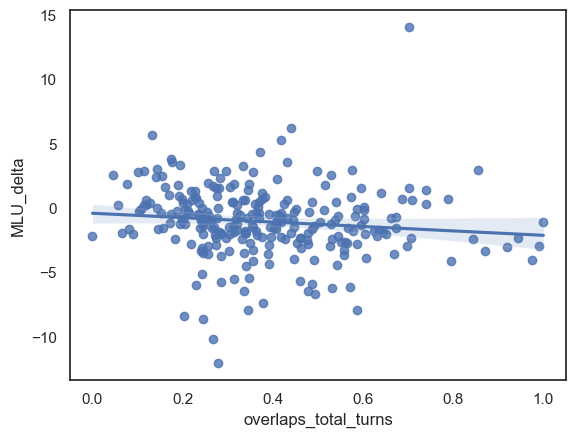

In [229]:
sns.regplot(data=halves_df_scaled,x='overlaps_total_turns',y='MLU_delta').get_figure().savefig("plots/overlaps_total_halves.png")

In [127]:
halves_df.loc[halves_df['complexity_match_MLU']>1].shape[0]/halves_df.shape[0]

0.11538461538461539

In [128]:
halves_df.loc[halves_df['complexity_match_AoA']>1].shape[0]/halves_df.shape[0]

0.18846153846153846

In [129]:
features_df.loc[features_df['complexity_match_MLU']>1].shape[0]/features_df.shape[0]

0.06048387096774194

In [130]:
features_df.loc[features_df['complexity_match_AoA']>1].shape[0]/features_df.shape[0]

0.08870967741935484

## Now, I'll check for corellation using different metrics (was using MLU so far)

In [131]:
all_chat_pairs_AoA = []
for student in student_grade_over_time:
    df = pd.DataFrame.from_dict(student_grade_over_time[student])
    all_chat_pairs_AoA.append(df.loc[df['AOA_delta']>0])
all_chat_pairs_AoA = pd.concat(all_chat_pairs_AoA)

previous_chats_AoA = [chatrooms[chat_index-2] for chat_index in all_chat_pairs_AoA['previous_chat_index']]
features_df_AoA = pd.DataFrame.from_dict({
    "scaffolding_ratio": all_chat_pairs_AoA['prev_scaffolding_ratio'],
    "overlaps": all_chat_pairs_AoA['prev_overlaps'],
    "teacher_easy": all_chat_pairs_AoA['prev_complexity_match'],
    'complexity_match': abs(1-all_chat_pairs_AoA['prev_complexity_match'])
})

y_AoA = np.array(all_chat_pairs_AoA['AOA_delta'])

features_df_AoA['delta'] = y_AoA
model_AoA = smf.ols('delta ~ teacher_easy + complexity_match + scaffolding_ratio + overlaps', data=features_df_AoA)
results_AoA = model_AoA.fit()

print(results_AoA.summary())

In [132]:
all_chat_pairs_WF = []
for student in student_grade_over_time:
    df = pd.DataFrame.from_dict(student_grade_over_time[student])
    all_chat_pairs_WF.append(df.loc[df['WF_delta']>0])
all_chat_pairs_WF = pd.concat(all_chat_pairs_WF)

previous_chats_WF = [chatrooms[chat_index-2] for chat_index in all_chat_pairs_WF['previous_chat_index']]
features_df_WF = pd.DataFrame.from_dict({
    "scaffolding_ratio": all_chat_pairs_WF['prev_scaffolding_ratio'],
    "overlaps": all_chat_pairs_WF['prev_overlaps'],
    "teacher_easy": all_chat_pairs_WF['prev_complexity_match'],
    'complexity_match': abs(1-all_chat_pairs_WF['prev_complexity_match'])
})

y_WF = np.array(all_chat_pairs_WF['WF_delta'])

features_df_WF['delta'] = y_WF
model_WF = smf.ols('delta ~ teacher_easy + complexity_match + scaffolding_ratio + overlaps', data=features_df_WF)
results_WF = model_WF.fit()

print(results_WF.summary())

In [133]:
sns.regplot(data=features_df_WF, x="overlaps", y="delta")

In [134]:
sns.regplot(data=features_df_WF, x="teacher_easy", y="delta")

In [135]:
all_chat_pairs_utt_ratio = []
for student in student_grade_over_time:
    df = pd.DataFrame.from_dict(student_grade_over_time[student])
    all_chat_pairs_utt_ratio.append(df.loc[df['utt_ratio_delta']>0])
all_chat_pairs_utt_ratio = pd.concat(all_chat_pairs_utt_ratio)

features_df_utt_ratio = pd.DataFrame.from_dict({
    "scaffolding_ratio": all_chat_pairs_utt_ratio['prev_scaffolding_ratio'],
    "overlaps": all_chat_pairs_utt_ratio['prev_overlaps'],
    "teacher_easy": all_chat_pairs_utt_ratio['prev_complexity_match'],
    'complexity_match': abs(1-all_chat_pairs_utt_ratio['prev_complexity_match'])
})
y_utt_ratio = np.array(all_chat_pairs_utt_ratio['utt_ratio_delta'])

features_df_utt_ratio['delta'] = y_utt_ratio
model_utt_ratio = smf.ols('delta ~ teacher_easy + complexity_match + scaffolding_ratio + overlaps', data=features_df_utt_ratio)
results_utt_ratio = model_utt_ratio.fit()

print(results_utt_ratio.summary())

In [136]:
all_chat_pairs_word_ratio = []
for student in student_grade_over_time:
    df = pd.DataFrame.from_dict(student_grade_over_time[student])
    all_chat_pairs_word_ratio.append(df.loc[df['word_ratio_delta']>0])
all_chat_pairs_word_ratio = pd.concat(all_chat_pairs_word_ratio)

features_df_word_ratio = pd.DataFrame.from_dict({
    "scaffolding_ratio": all_chat_pairs_word_ratio['prev_scaffolding_ratio'],
    "overlaps": all_chat_pairs_word_ratio['prev_overlaps'],
    "teacher_easy": all_chat_pairs_word_ratio['prev_complexity_match'],
    'complexity_match': abs(1-all_chat_pairs_word_ratio['prev_complexity_match'])
})

y_word_ratio = np.array(all_chat_pairs_word_ratio['word_ratio_delta'])

features_df_word_ratio['delta'] = y_word_ratio
model_word_ratio = smf.ols('delta ~ teacher_easy + complexity_match + scaffolding_ratio + overlaps', data=features_df_word_ratio)
results_word_ratio = model_word_ratio.fit()

print(results_word_ratio.summary())

In [137]:
sns.regplot(data=features_df_word_ratio, x='complexity_match', y='delta')

I have found that the easier the teacher's language is, the better the progress. Now I will check for the absolute value of the teacher's language complexity, instead of a ratio.

## I check which measure predicts the student's CEFR level best

In [138]:
from alive_progress import alive_bar
# features - different measures per chat
# dependent variable - CEFR
# classification

CEFR_prediction_data = []

with alive_bar(len(chatrooms), force_tty=True) as bar:
    for i, chat in enumerate(chatrooms):
        CEFR_prediction_data.append({
            # features
            'MLU': chat_MLU(chat)[2],
            'AoA': chat_AoA(chat)[2],
            'WF': chat_WF(chat)[2],
            'TTR': chat_TTR(chat)[2],
            'flesch_kincaid': chat_flesch_kincaid(chat)[2],
            'flesch': chat_flesch(chat)[2],
            'gunning_fog': chat_gunning_fog(chat)[2],

            # dep variable
            'grade': metadata.iloc[i]['student.cefr.level']
        })
        bar()

In [139]:
pd.DataFrame(CEFR_prediction_data)

In [141]:
chat_scores = json.load(open('chat_scores.txt'))
chat_scores = pd.DataFrame(chat_scores)
chat_scores

,MLU,AoA,WF,TTR,flesch_kincaid,flesch,gunning_fog,grade
0,7.500000,5.328807,2931.982976,0.473354,3.858260,80.776970,5.046933,B1
1,11.333333,5.172259,2052.971980,0.348936,3.802101,84.185308,6.210145,C1
2,7.888889,5.394083,3699.349007,0.461326,2.888796,84.472204,5.799889,B2
3,5.781250,5.924266,4993.576932,0.605000,4.941664,70.148848,7.977847,B1
4,11.285714,4.642768,3334.703033,0.326975,2.557222,93.729046,5.520782,C1
...,...,...,...,...,...,...,...,...
255,7.750000,4.779736,1873.201698,0.396290,3.066743,88.563903,6.366717,B2
256,15.545455,5.800181,3304.124696,0.415603,6.680699,75.681429,9.996978,C2
257,6.173333,4.725736,7227.780663,0.518519,1.656020,92.737469,4.330216,C2
258,5.415094,3.674978,3529.244317,0.448649,2.047674,90.717791,4.341682,B2


In [142]:
chat_scores['words_ratio'] = [chat_words_proportion(chat) for chat in chatrooms]
chat_scores['utterance_ratio'] = [chat_utterance_proportion(chat) for chat in chatrooms]

In [143]:
chat_scores['flesch'] = -chat_scores['flesch'] # because its decrease should indicate higher level
chat_scores

,MLU,AoA,WF,TTR,flesch_kincaid,flesch,gunning_fog,grade
0,7.500000,5.328807,2931.982976,0.473354,3.858260,-80.776970,5.046933,B1
1,11.333333,5.172259,2052.971980,0.348936,3.802101,-84.185308,6.210145,C1
2,7.888889,5.394083,3699.349007,0.461326,2.888796,-84.472204,5.799889,B2
3,5.781250,5.924266,4993.576932,0.605000,4.941664,-70.148848,7.977847,B1
4,11.285714,4.642768,3334.703033,0.326975,2.557222,-93.729046,5.520782,C1
...,...,...,...,...,...,...,...,...
255,7.750000,4.779736,1873.201698,0.396290,3.066743,-88.563903,6.366717,B2
256,15.545455,5.800181,3304.124696,0.415603,6.680699,-75.681429,9.996978,C2
257,6.173333,4.725736,7227.780663,0.518519,1.656020,-92.737469,4.330216,C2
258,5.415094,3.674978,3529.244317,0.448649,2.047674,-90.717791,4.341682,B2


In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
chat_scores_features_scaled = scaler.fit_transform(chat_scores.drop('grade', axis=1))
pd.DataFrame(chat_scores_features_scaled)

,0,1,2,3,4,5,6
0,0.223581,1.222471,-0.492663,0.442798,0.503865,0.750409,-0.421585
1,1.437886,0.964950,-0.945071,-1.341883,0.467614,0.301912,0.272637
2,0.346771,1.329852,-0.097717,0.270262,-0.121928,0.264160,0.027790
3,-0.320876,2.202005,0.568394,2.331155,1.203206,2.148945,1.327628
4,1.422801,0.093935,-0.285392,-1.656892,-0.335959,-0.953931,-0.138785
...,...,...,...,...,...,...,...
255,0.302775,0.319249,-1.037595,-0.662628,-0.007062,-0.274259,0.366082
256,2.772181,1.997884,-0.301130,-0.385601,2.325758,1.420923,2.532676
257,-0.196674,0.230418,1.718290,1.090645,-0.917689,-0.823452,-0.849333
258,-0.436865,-1.498084,-0.185266,0.088416,-0.664874,-0.557686,-0.842490


In [145]:
target_cefr = chat_scores['grade']

In [146]:
feature_names = list(chat_scores)
feature_names.remove('grade')
feature_names

['MLU', 'AoA', 'WF', 'TTR', 'flesch_kincaid', 'flesch', 'gunning_fog']

In [147]:
scaled_df = pd.DataFrame(chat_scores_features_scaled)
scaled_df.columns = feature_names
scaled_df['grade'] = chat_scores['grade']
scaled_df

,MLU,AoA,WF,TTR,flesch_kincaid,flesch,gunning_fog,grade
0,0.223581,1.222471,-0.492663,0.442798,0.503865,0.750409,-0.421585,B1
1,1.437886,0.964950,-0.945071,-1.341883,0.467614,0.301912,0.272637,C1
2,0.346771,1.329852,-0.097717,0.270262,-0.121928,0.264160,0.027790,B2
3,-0.320876,2.202005,0.568394,2.331155,1.203206,2.148945,1.327628,B1
4,1.422801,0.093935,-0.285392,-1.656892,-0.335959,-0.953931,-0.138785,C1
...,...,...,...,...,...,...,...,...
255,0.302775,0.319249,-1.037595,-0.662628,-0.007062,-0.274259,0.366082,B2
256,2.772181,1.997884,-0.301130,-0.385601,2.325758,1.420923,2.532676,C2
257,-0.196674,0.230418,1.718290,1.090645,-0.917689,-0.823452,-0.849333,C2
258,-0.436865,-1.498084,-0.185266,0.088416,-0.664874,-0.557686,-0.842490,B2


In [148]:
from sklearn.ensemble import RandomForestClassifier

importance_scores = []
for _ in range(10):
    clf = RandomForestClassifier()
    clf.fit(chat_scores_features_scaled, target_cefr)
    importance_scores.append(clf.feature_importances_)

In [149]:
importance_means = [np.mean(scores) for scores in list(map(list, zip(*importance_scores)))]
importance_means

[0.1800407933272711,
 0.17378774413970782,
 0.09305498399836956,
 0.11356863752914545,
 0.14919490211422298,
 0.1501123248007795,
 0.14024061409050362]

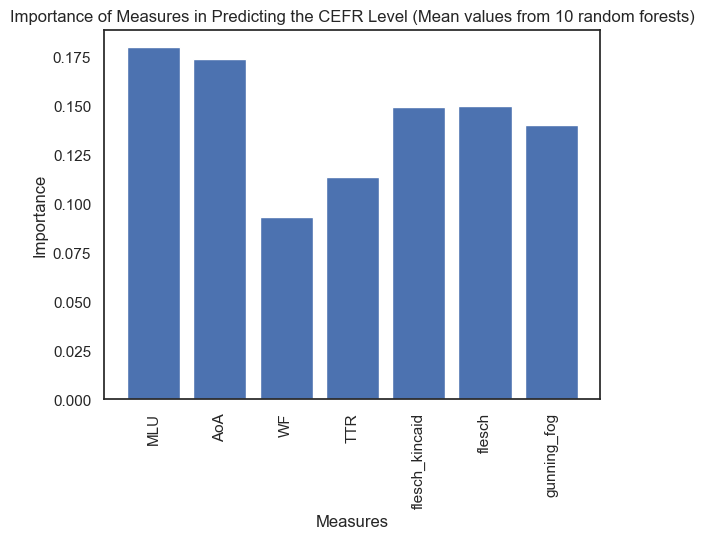

In [150]:
plt.bar(feature_names, importance_means)
plt.xlabel('Measures')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Importance of Measures in Predicting the CEFR Level (Mean values from 10 random forests)')
plt.savefig('plots/feature_importance.png', bbox_inches='tight')
plt.show()

# N-grams for halves


In [151]:
# Teachers scaffolding utts only X_scaffolding_halves
X_scaffolding_halves = []
for chat_index in halves_df.index:
    chat = chatrooms[chat_index]
    chat1 = chat[:int(len(chat)/2)]
    
    scaffolding_teacher_utts = chat1[(chat1['seq.type'].str.contains('scaffolding')) & (chat1['role'] == 'teacher')]['anonymised']
    tokens = scaffolding_teacher_utts.apply(tokenize_and_preprocess)
    all_tokens = sum(tokens, [])
    tokens_joined = ' '.join(list(all_tokens))
    X_scaffolding_halves.append(tokens_joined)
X_scaffolding_halves = np.array(X_scaffolding_halves)

In [152]:
# Teachers all utts X_halves
X_halves = []
for chat_index in halves_df.index:
    chat = chatrooms[chat_index]
    chat1 = chat[:int(len(chat)/2)]
    
    teacher_utts = chat1.loc[chat1['role'] == 'teacher']['anonymised']
    tokens = teacher_utts.apply(tokenize_and_preprocess)
    all_tokens = sum(tokens, [])
    tokens_joined = ' '.join(list(all_tokens))
    X_halves.append(tokens_joined)
X_halves = np.array(X_halves)

In [153]:
X_scaffolding_halves.shape

(260,)

In [154]:
X_halves.shape

(260,)

In [155]:
# All tutor utterances

cv_halves = CountVectorizer(analyzer = 'word',ngram_range=(2,3), min_df=3)
X_halves_cv = cv_halves.fit_transform(X_halves)

In [156]:
X_halves_cv.shape

(260, 8797)

In [157]:
y_halves = halves_df['MLU_delta']
y_halves.shape

(260,)

In [158]:
reg_ngram_halves = LinearRegression()
reg_ngram_halves.fit(X_halves_cv, y_halves)
feature_names_halves = cv_halves.get_feature_names_out()

In [159]:
results_halves = [(coef, ngram) for coef, ngram in zip(reg_ngram_halves.coef_, feature_names_halves)]
sorted_features_halves = sorted(results_halves, key=lambda x: x[0], reverse=True)

In [160]:
top_features_halves = sorted_features_halves[:50]

# Print top N-grams and their coefficients
print("Top Predictive N-grams overall for dialogue halves (with coefficients):")
for coef, feature_name in top_features_halves:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Predictive N-grams overall for dialogue halves (with coefficients):
- talk about (Coef: 0.2213)
- is fine (Coef: 0.1815)
- present simple (Coef: 0.1667)
- is good (Coef: 0.1596)
- yes and (Coef: 0.1514)
- to talk (Coef: 0.1462)
- to talk about (Coef: 0.1461)
- am going (Coef: 0.1454)
- thanks so (Coef: 0.1407)
- at the moment (Coef: 0.1401)
- the moment (Coef: 0.1401)
- because it (Coef: 0.1324)
- from the (Coef: 0.1277)
- like to (Coef: 0.1274)
- course at (Coef: 0.1269)
- good yes (Coef: 0.1269)
- this week (Coef: 0.1198)
- no problem (Coef: 0.1184)
- to ask (Coef: 0.1178)
- this is (Coef: 0.1171)
- yes that is (Coef: 0.1158)
- to the (Coef: 0.1147)
- we are (Coef: 0.1141)
- shall we (Coef: 0.1136)
- is bit (Coef: 0.1087)
- on your (Coef: 0.1079)
- ok with (Coef: 0.1075)
- so you can (Coef: 0.1071)
- have the (Coef: 0.1057)
- you see (Coef: 0.1050)
- next week (Coef: 0.1049)
- it is actually (Coef: 0.1027)
- we go (Coef: 0.1026)
- student just (Coef: 0.1017)
- now you (Coef: 0.10

In [161]:
least_features_halves = list(reversed(sorted_features_halves[-50:]))

# Print top N-grams and their coefficients
print("Top Negatively Predictive N-grams overall for dialogue halves (with coefficients):")
for coef, feature_name in least_features_halves:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Negatively Predictive N-grams overall for dialogue halves (with coefficients):
- might be (Coef: -0.2092)
- need to (Coef: -0.1902)
- you need to (Coef: -0.1755)
- have to (Coef: -0.1662)
- think about (Coef: -0.1648)
- and then (Coef: -0.1636)
- to me (Coef: -0.1571)
- my husband (Coef: -0.1546)
- ok thanks (Coef: -0.1527)
- in your (Coef: -0.1521)
- know what (Coef: -0.1486)
- you need (Coef: -0.1472)
- it is (Coef: -0.1461)
- the past (Coef: -0.1391)
- like it (Coef: -0.1325)
- lot of (Coef: -0.1299)
- my son (Coef: -0.1287)
- for the (Coef: -0.1237)
- is more (Coef: -0.1231)
- come back (Coef: -0.1218)
- is not (Coef: -0.1215)
- makes sense (Coef: -0.1187)
- back to (Coef: -0.1161)
- out of (Coef: -0.1146)
- that is ok (Coef: -0.1136)
- will come (Coef: -0.1119)
- topic sentence (Coef: -0.1116)
- is that (Coef: -0.1106)
- with your (Coef: -0.1102)
- come back to (Coef: -0.1084)
- had to (Coef: -0.1076)
- is the (Coef: -0.1070)
- on our (Coef: -0.1053)
- keep going (Coef: -0.104

In [162]:
# Scaffolding utterances

cv_scaffolding_halves = CountVectorizer(analyzer = 'word',ngram_range=(2,3), min_df=3)
X_scaffolding_halves_cv = cv_scaffolding_halves.fit_transform(X_scaffolding_halves)

In [163]:
X_scaffolding_halves_cv.shape

(260, 1564)

In [164]:
reg_ngram_scaffolding_halves = LinearRegression()
reg_ngram_scaffolding_halves.fit(X_scaffolding_halves_cv, y_halves)
feature_names_scaffolding_halves = cv_scaffolding_halves.get_feature_names_out()

In [165]:
results_scaffolding_halves = [(coef, ngram) for coef, ngram in zip(reg_ngram_scaffolding_halves.coef_, feature_names_scaffolding_halves)]
sorted_features_scaffolding_halves = sorted(results_scaffolding_halves, key=lambda x: x[0], reverse=True)

In [166]:
top_features_scaffolding_halves = sorted_features_scaffolding_halves[:50]

# Print top N-grams and their coefficients
print("Top Predictive N-grams overall for dialogue halves (with coefficients):")
for coef, feature_name in top_features_scaffolding_halves:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Predictive N-grams overall for dialogue halves (with coefficients):
- yes exactly (Coef: 2.2248)
- but only (Coef: 1.8181)
- in the uk (Coef: 1.0459)
- they want (Coef: 1.0394)
- do not (Coef: 1.0126)
- does not (Coef: 0.9654)
- oh like (Coef: 0.9045)
- what about (Coef: 0.8712)
- is important (Coef: 0.8621)
- thanks so (Coef: 0.8463)
- down the (Coef: 0.8338)
- the expression (Coef: 0.8216)
- see what (Coef: 0.8155)
- present simple (Coef: 0.7885)
- what they (Coef: 0.7439)
- or just (Coef: 0.7428)
- the same (Coef: 0.7254)
- could be (Coef: 0.6998)
- at the (Coef: 0.6729)
- and they (Coef: 0.6728)
- can not (Coef: 0.6725)
- sense of (Coef: 0.6616)
- to have (Coef: 0.6337)
- person is (Coef: 0.6310)
- it out (Coef: 0.6116)
- would be (Coef: 0.6047)
- have you (Coef: 0.6039)
- to talk (Coef: 0.5920)
- to do (Coef: 0.5905)
- that is good (Coef: 0.5841)
- it is called (Coef: 0.5811)
- we use (Coef: 0.5707)
- can take (Coef: 0.5668)
- time and (Coef: 0.5617)
- and they are (Coef: 0.56

In [167]:
least_features_scaffolding_halves = list(reversed(sorted_features_scaffolding_halves[-50:]))

# Print top N-grams and their coefficients
print("Top Negatively Predictive N-grams overall for dialogue halves (with coefficients):")
for coef, feature_name in least_features_scaffolding_halves:
    print(f"- {feature_name} (Coef: {coef:.4f})")

Top Negatively Predictive N-grams overall for dialogue halves (with coefficients):
- idea of (Coef: -2.2828)
- was the (Coef: -2.0885)
- just say (Coef: -2.0233)
- he was (Coef: -1.8714)
- the uk (Coef: -1.6937)
- let us (Coef: -1.4429)
- you could (Coef: -1.4421)
- is called (Coef: -1.3240)
- think about (Coef: -1.2319)
- made up (Coef: -1.2271)
- has been (Coef: -1.2199)
- is made (Coef: -1.2101)
- for plans (Coef: -1.1982)
- said that (Coef: -1.1814)
- used in the (Coef: -1.1506)
- yes so (Coef: -1.1119)
- what is (Coef: -1.0829)
- very good (Coef: -1.0439)
- two or (Coef: -1.0208)
- and also (Coef: -1.0183)
- about your (Coef: -0.9914)
- that is (Coef: -0.9266)
- student so (Coef: -0.9127)
- present perfect (Coef: -0.8985)
- used in (Coef: -0.8930)
- going to (Coef: -0.8581)
- to the (Coef: -0.8381)
- past simple (Coef: -0.8286)
- was not (Coef: -0.8180)
- ok thanks (Coef: -0.7907)
- on the (Coef: -0.7617)
- is more (Coef: -0.7613)
- hold on (Coef: -0.6867)
- in france (Coef: -0.67

In [ ]:
# LATEX table generations

In [201]:
#top_feeatures_full, scaff
for (a, ca), (b, cb), (c, cc), (d, cd) in zip(top_features_full[:20], top_features_scaff[:20], top_features_halves[:20], top_features_scaffolding_halves[:20]):
    # print(f"{a} & {ca} & {b} & {cb} & {c} & {cc} & {d} & {cd}//")
    print(f"{cd} & {d:.3f}\\\\")

yes exactly & 2.225\\
but only & 1.818\\
in the uk & 1.046\\
they want & 1.039\\
do not & 1.013\\
does not & 0.965\\
oh like & 0.904\\
what about & 0.871\\
is important & 0.862\\
thanks so & 0.846\\
down the & 0.834\\
the expression & 0.822\\
see what & 0.815\\
present simple & 0.788\\
what they & 0.744\\
or just & 0.743\\
the same & 0.725\\
could be & 0.700\\
at the & 0.673\\
and they & 0.673\\


In [246]:
sample_context = """
STUDENT: hi. Another benefit of exploring space is that there are massive resources and elements. such as precious metals or helium and so on where we may find them on asteroids and planets. 

TEACHER: OK thanks <STUDENT> - some good stuff there...have you already done more that's coming? 

STUDENT: no.. 

TEACHER: No that's fine! That's great start...hold on a sec... a great start i mean. 

STUDENT: as a consequence, a lack of resources on the earth will be solved. 

TEACHER: Can i suggest a slightly more general sentence (a topic sentence) to start before we look at your words exactly.... 

STUDENT: yes.. I need it. 

TEACHER: Ah yes ... great idea to connect with the idea there yes welldone. OK OK so....remember the 'category' here? POlitical? No! It's ________ benefits...? 

STUDENT: it is economical benefits. 



GENERATED_COMPLEX: Great! Ah-ha i felt that! So now we can try to paraphrase...right? Can you tell me your words, and i'll give you phrases to rewrite them?

GENERATED_BASE:Ah i see! Economic benefits, great choice! Let's dive into those, shall we? So, if we explore space and have access to those resources, we can _______________________________ (complete the sentence). What do you think?

REFERENCE:yes that's it (economic benefits). sorry internet problems!"""

for line in sample_context.split('\n'):
    if(':' in line):
        print(F"{line.split(':')[0]} & {line.split(':')[1]}\\\\")

STUDENT &  hi. Another benefit of exploring space is that there are massive resources and elements. such as precious metals or helium and so on where we may find them on asteroids and planets. \\
TEACHER &  OK thanks <STUDENT> - some good stuff there...have you already done more that's coming? \\
STUDENT &  no.. \\
TEACHER &  No that's fine! That's great start...hold on a sec... a great start i mean. \\
STUDENT &  as a consequence, a lack of resources on the earth will be solved. \\
TEACHER &  Can i suggest a slightly more general sentence (a topic sentence) to start before we look at your words exactly.... \\
STUDENT &  yes.. I need it. \\
TEACHER &  Ah yes ... great idea to connect with the idea there yes welldone. OK OK so....remember the 'category' here? POlitical? No! It's ________ benefits...? \\
STUDENT &  it is economical benefits. \\
GENERATED_COMPLEX &  Great! Ah-ha i felt that! So now we can try to paraphrase...right? Can you tell me your words, and i'll give you phrases to 